[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Sandip029/Credit_Score/blob/main/Credit_Score_Final_Project_Classification.ipynb)


# **Problem Statement:**

In the financial industry, accurately assessing the creditworthiness of individuals is crucial for mitigating risk and ensuring responsible lending practices. Traditional methods of credit score prediction often rely on historical credit data, which may not fully capture the evolving financial behavior of individuals. This project aims to develop a robust classification model that predicts an individual's credit score based on various features, including transaction history, payment patterns, and demographic information.

# **Objective:**

The primary challenge is to build a robust model that can classify credit scores into predefined categories (e.g., Standard, Good, Poor) with high accuracy. This model should leverage a diverse set of features to predict credit scores and provide actionable insights that can help financial institutions make informed lending decisions.

# **About Dataset:**

ID                          
Customer_ID                 
Month                     
Name                       
Age                       
SSN                       
Occupation                 
Annual_Income             
Monthly_Inhand_Salary     
Num_Bank_Accounts         
Num_Credit_Card           
Interest_Rate             
Num_of_Loan               
Type_of_Loan               
Delay_from_due_date       
Num_of_Delayed_Payment    
Changed_Credit_Limit      
Num_Credit_Inquiries      
Credit_Mix                 
Outstanding_Debt          
Credit_Utilization_Ratio  
Credit_History_Age        
Payment_of_Min_Amount      
Total_EMI_per_month       
Amount_invested_monthly   
Payment_Behaviour          
Monthly_Balance           
Credit_Score              

# Load the libraries

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install association-metrics -q

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install gdown -q

In [ ]:
import numpy as np
import pandas as pd
import gdown
import seaborn as sns
import matplotlib.pyplot as plt
import association_metrics as am
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import optuna
from optuna import Trial
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix
from google.colab import drive
import joblib

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load the dataset

In [ ]:
url = f'https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

data = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D
To: /content/dataset.csv
100%|██████████| 30.2M/30.2M [00:00<00:00, 32.0MB/s]


# Looking into the data

In [ ]:
data.sample(5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
18644,33598,28804,5,Ryan Vlastelicao,26.0,967684738.0,Musician,30619.710,1965.121357,5.0,...,Standard,701.44,26.256496,295.0,Yes,298.521143,33.724675,High_spent_Medium_value_payments,400.012641,Standard
19088,34266,38778,1,Lucianag,19.0,444804079.0,Journalist,73713.480,6269.790000,4.0,...,Standard,1462.83,20.992914,200.0,Yes,321.959777,80.671364,Low_spent_Small_value_payments,6.736601,Poor
60146,95852,49255,3,Jedd,24.0,95770243.0,Lawyer,10004.805,984.733750,10.0,...,Bad,4532.65,33.798107,96.0,Yes,43.181293,34.622087,Low_spent_Small_value_payments,305.923123,Poor
48366,78180,47561,7,Lucianab,19.0,375460915.0,Architect,19575.890,1559.324167,5.0,...,Standard,2394.38,31.334934,208.0,Yes,54.090796,35.447778,High_spent_Small_value_payments,326.393843,Poor
88145,137851,28305,2,Ulfi,18.0,373834458.0,Teacher,19852.640,1921.386667,5.0,...,Standard,1355.63,35.495001,196.0,NM,31.764848,12.846632,Low_spent_Large_value_payments,309.417358,Standard


In [ ]:
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [ ]:
data.shape

(100000, 28)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [ ]:
data.describe()

,ID,Customer_ID,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,...,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,80631.500000,25982.666640,4.500000,33.316340,5.004617e+08,50505.123449,4197.270835,5.368820,5.533570,14.53208,...,21.08141,13.313120,10.470323,5.798250,1426.220376,32.285173,221.220460,107.699208,55.101315,392.697586
std,43301.486619,14340.543051,2.291299,10.764812,2.908267e+08,38299.422093,3186.432497,2.593314,2.067098,8.74133,...,14.80456,6.237166,6.609481,3.867826,1155.129026,5.116875,99.680716,132.267056,39.006932,201.652719
min,5634.000000,1006.000000,1.000000,14.000000,8.134900e+04,7005.930000,303.645417,0.000000,0.000000,1.00000,...,0.00000,0.000000,0.500000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760
25%,43132.750000,13664.500000,2.750000,24.000000,2.451686e+08,19342.972500,1626.594167,3.000000,4.000000,7.00000,...,10.00000,9.000000,5.380000,3.000000,566.072500,28.052567,144.000000,29.268886,27.959111,267.615983
50%,80631.500000,25777.000000,4.500000,33.000000,5.006886e+08,36999.705000,3095.905000,5.000000,5.000000,13.00000,...,18.00000,14.000000,9.400000,5.000000,1166.155000,32.305784,219.000000,66.462304,45.156550,333.865366
75%,118130.250000,38385.000000,6.250000,42.000000,7.560027e+08,71683.470000,5957.715000,7.000000,7.000000,20.00000,...,28.00000,18.000000,14.850000,8.000000,1945.962500,36.496663,302.000000,147.392573,71.295797,463.215683
max,155629.000000,50999.000000,8.000000,56.000000,9.999934e+08,179987.280000,15204.633333,11.000000,11.000000,34.00000,...,62.00000,25.000000,29.980000,17.000000,4998.070000,50.000000,404.000000,1779.103254,434.191089,1183.930696


In [ ]:
data.nunique()

,0
ID,100000
Customer_ID,12500
Month,8
Name,10128
Age,43
SSN,12500
Occupation,15
Annual_Income,12488
Monthly_Inhand_Salary,13241
Num_Bank_Accounts,12


# Exploratory Data Analysis

In [ ]:
data["Credit_Score"].value_counts()

,count
Credit_Score,
Standard,53174
Poor,28998
Good,17828


In [ ]:
data['Payment_Behaviour'].value_counts()

,count
Payment_Behaviour,
Low_spent_Small_value_payments,28580
High_spent_Medium_value_payments,18988
Low_spent_Medium_value_payments,14962
High_spent_Large_value_payments,14639
High_spent_Small_value_payments,12043
Low_spent_Large_value_payments,10788


In [ ]:
data["Month"].value_counts()

,count
Month,
1,12500
2,12500
3,12500
4,12500
5,12500
6,12500
7,12500
8,12500


In [ ]:
data["Occupation"].value_counts()

,count
Occupation,
Lawyer,7096
Engineer,6864
Architect,6824
Mechanic,6776
Scientist,6744
Accountant,6744
Developer,6720
Media_Manager,6720
Teacher,6672


In [ ]:
data["Num_Bank_Accounts"].value_counts()

,count
Num_Bank_Accounts,
6.0,13175
7.0,12999
8.0,12940
4.0,12343
5.0,12298
3.0,12107
9.0,5503
10.0,5329
1.0,4540


In [ ]:
data["Num_Credit_Card"].value_counts()

,count
Num_Credit_Card,
5.0,18903
7.0,17024
6.0,16932
4.0,14362
3.0,13560
8.0,5073
10.0,4962
9.0,4753
2.0,2196


In [ ]:
data["Num_of_Loan"].value_counts()

,count
Num_of_Loan,
3.0,15752
2.0,15712
4.0,15456
0.0,11408
1.0,11128
6.0,8144
7.0,7680
5.0,7528
9.0,3856


In [ ]:
data["Credit_Mix"].value_counts()

,count
Credit_Mix,
Standard,45848
Good,30384
Bad,23768


In [ ]:
data["Payment_of_Min_Amount"].value_counts()

,count
Payment_of_Min_Amount,
Yes,52326
No,35667
NM,12007


## Heatmap of Credit Score by Occupation

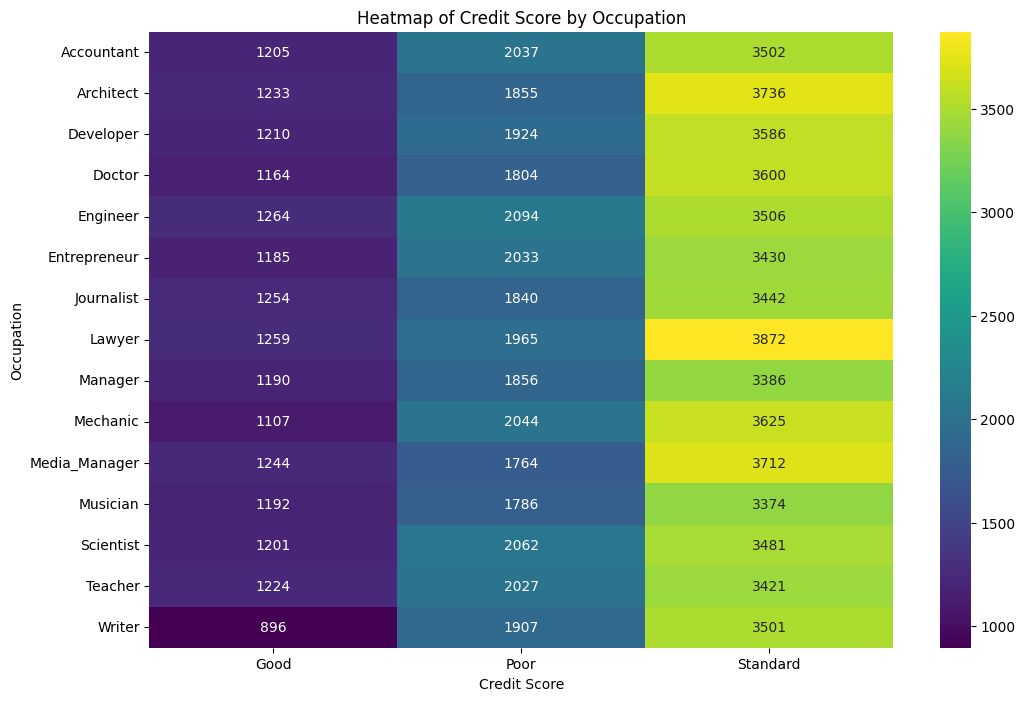

In [ ]:
cross_tab = pd.crosstab(data['Occupation'], data['Credit_Score'])

plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, cmap='viridis', fmt='d')

plt.xlabel('Credit Score')
plt.ylabel('Occupation')
plt.title('Heatmap of Credit Score by Occupation')
plt.show()

## Distribution of Age by Credit Score Category

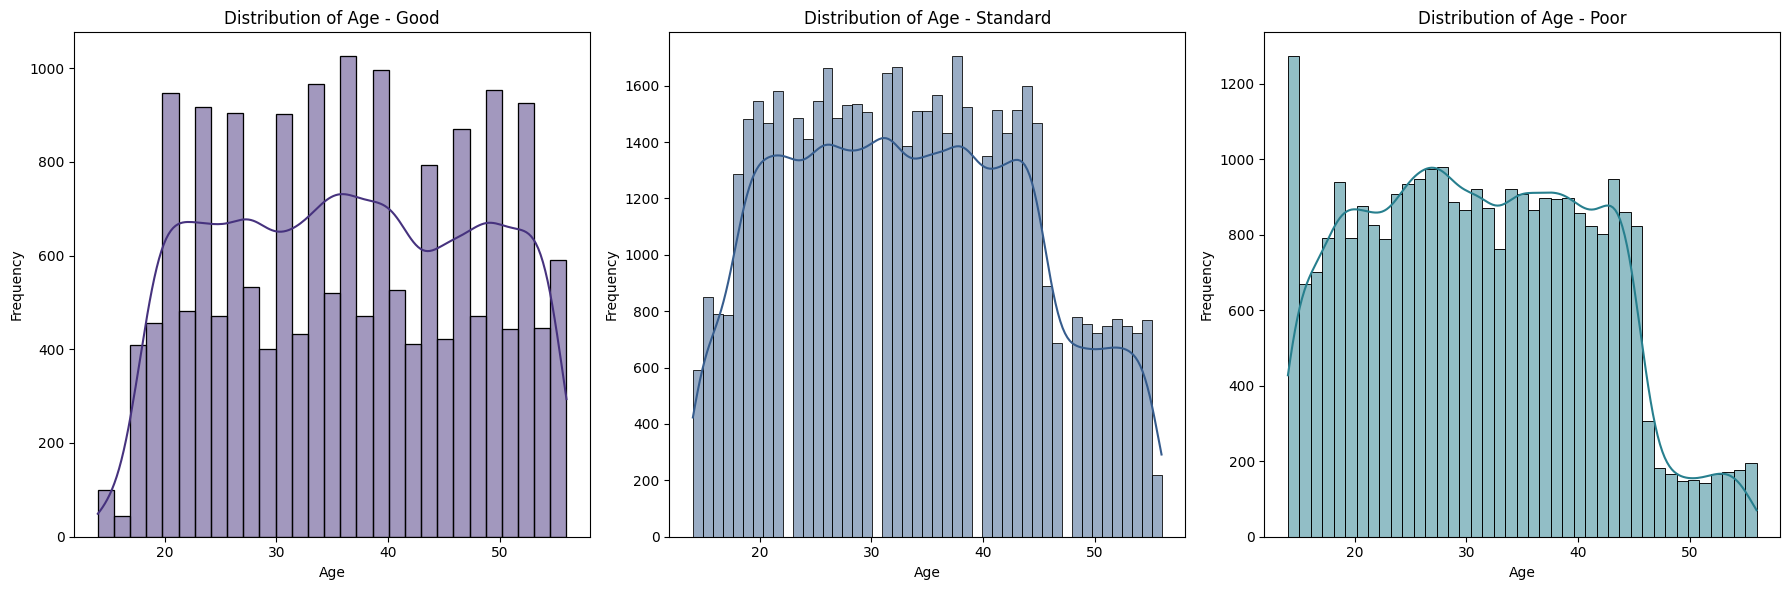

In [ ]:
plt.figure(figsize=(18, 6))

categories = ['Good', 'Standard', 'Poor']

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Age'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Age - {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Box Plot of Annual Income by Credit Score Category

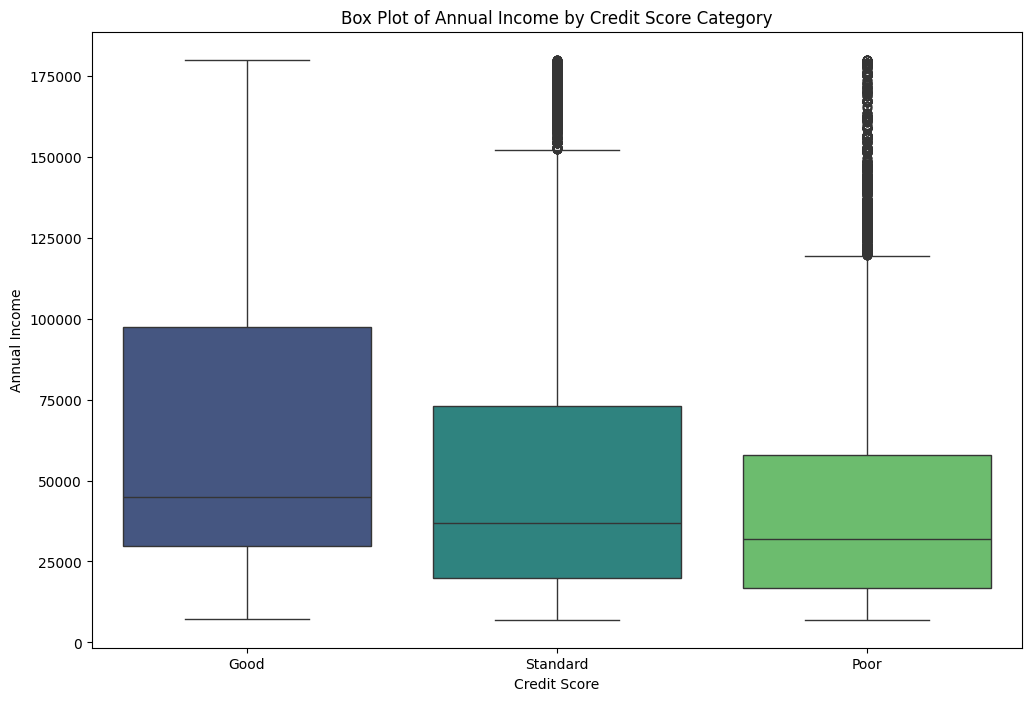

In [ ]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=data, x='Credit_Score', y='Annual_Income', palette='viridis')

plt.xlabel('Credit Score')
plt.ylabel('Annual Income')
plt.title('Box Plot of Annual Income by Credit Score Category')
plt.show()

## Distribution of Annual Income by Credit Score Category

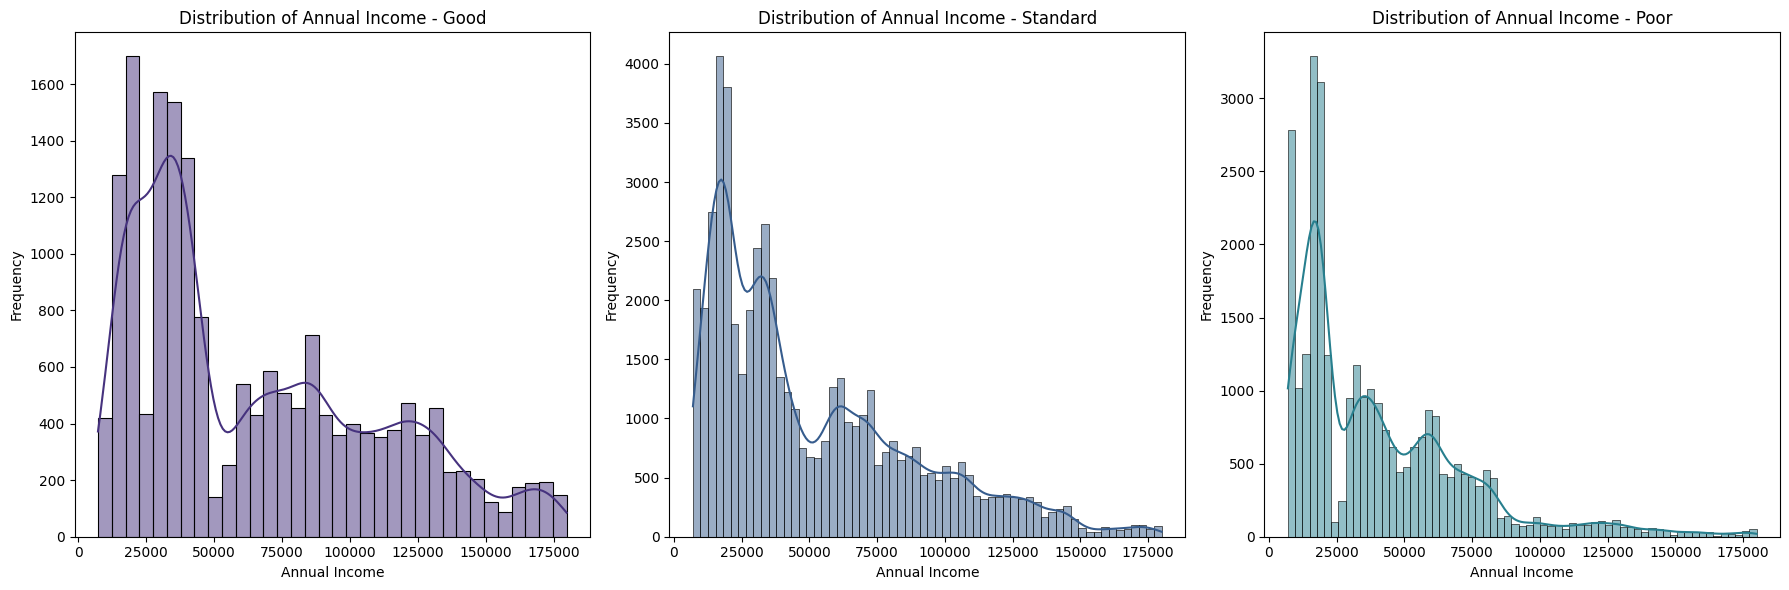

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Annual_Income'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Annual Income - {category}')
    plt.xlabel('Annual Income')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Box Plot of Monthly Inhand Salary by Credit Score Category

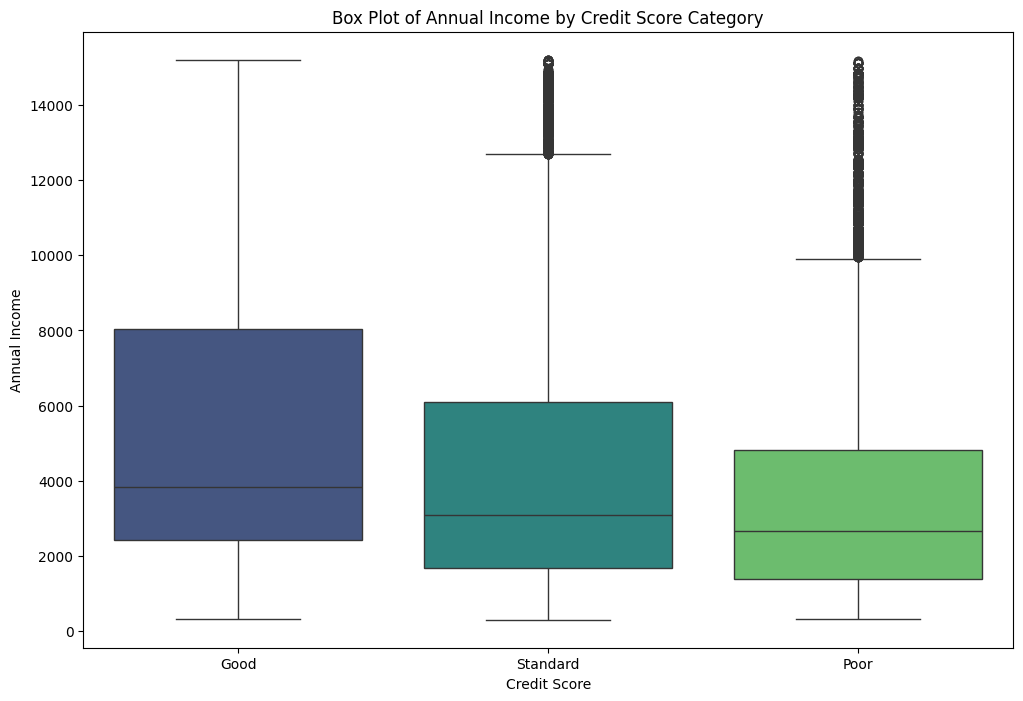

In [ ]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=data, x='Credit_Score', y='Monthly_Inhand_Salary', palette='viridis')

plt.xlabel('Credit Score')
plt.ylabel('Annual Income')
plt.title('Box Plot of Annual Income by Credit Score Category')
plt.show()

## Distribution of Monthly Inhand Salary by Credit Score Category

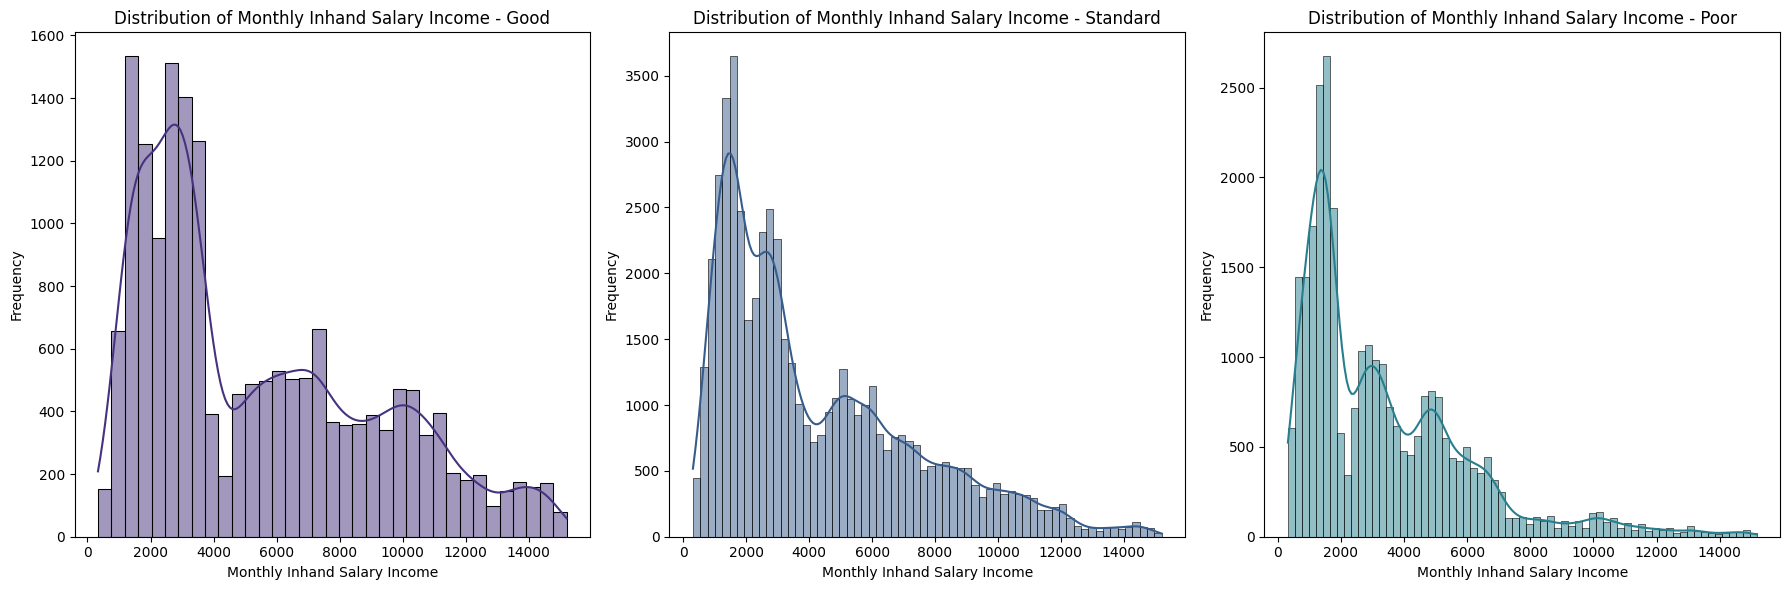

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Monthly_Inhand_Salary'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Monthly Inhand Salary Income - {category}')
    plt.xlabel('Monthly Inhand Salary Income')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Bank Accounts by Credit Score Category

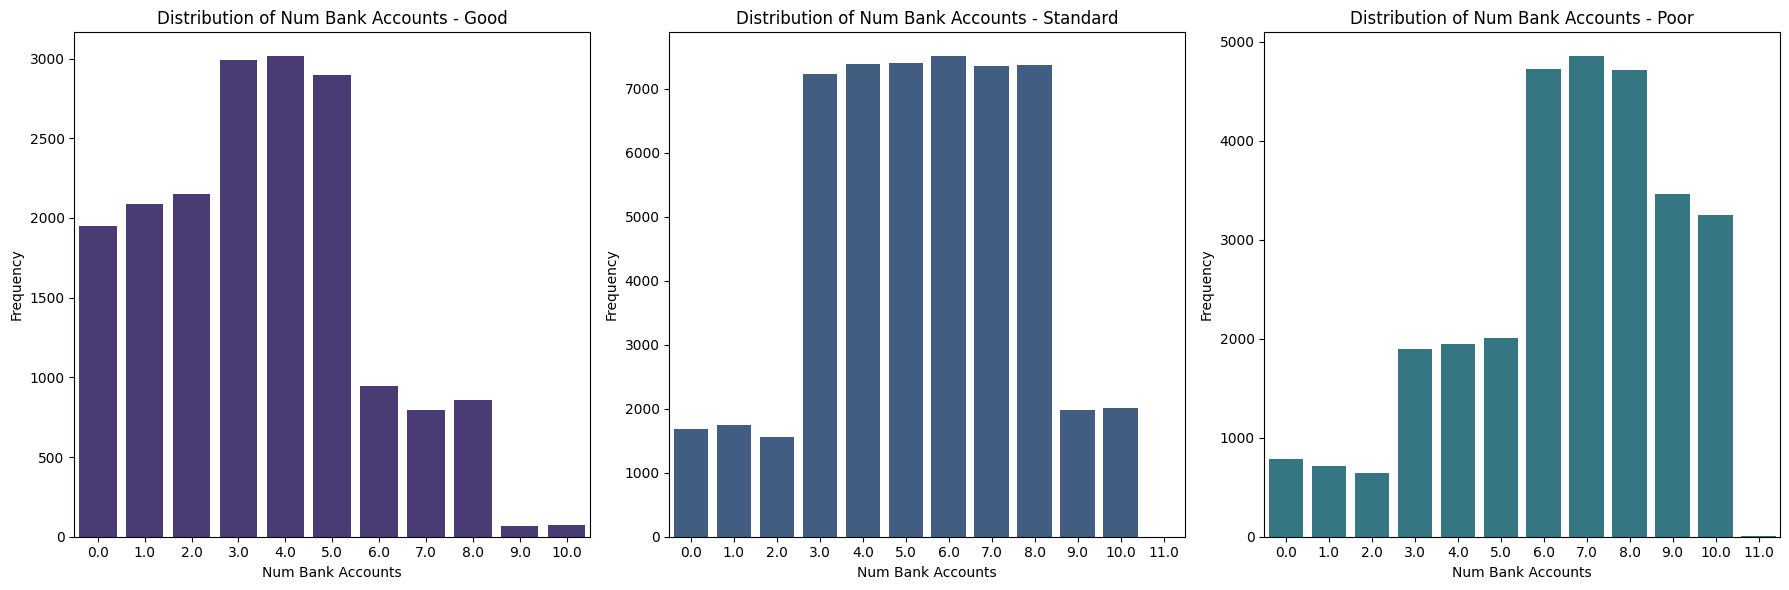

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_Bank_Accounts'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_Bank_Accounts'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num Bank Accounts - {category}')
    plt.xlabel('Num Bank Accounts')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Credit Card by Credit Score Category

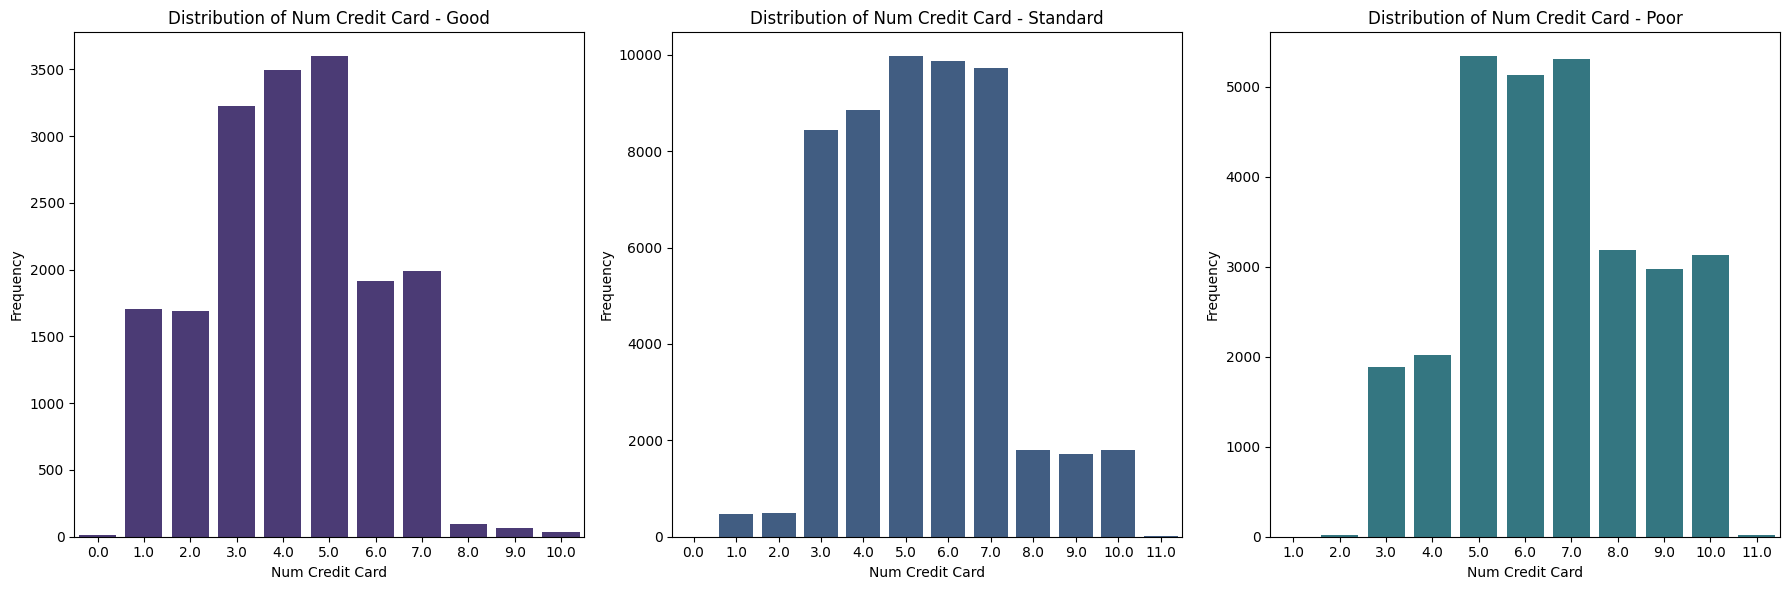

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_Credit_Card'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_Credit_Card'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num Credit Card - {category}')
    plt.xlabel('Num Credit Card')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Interest Rate by Credit Score Category

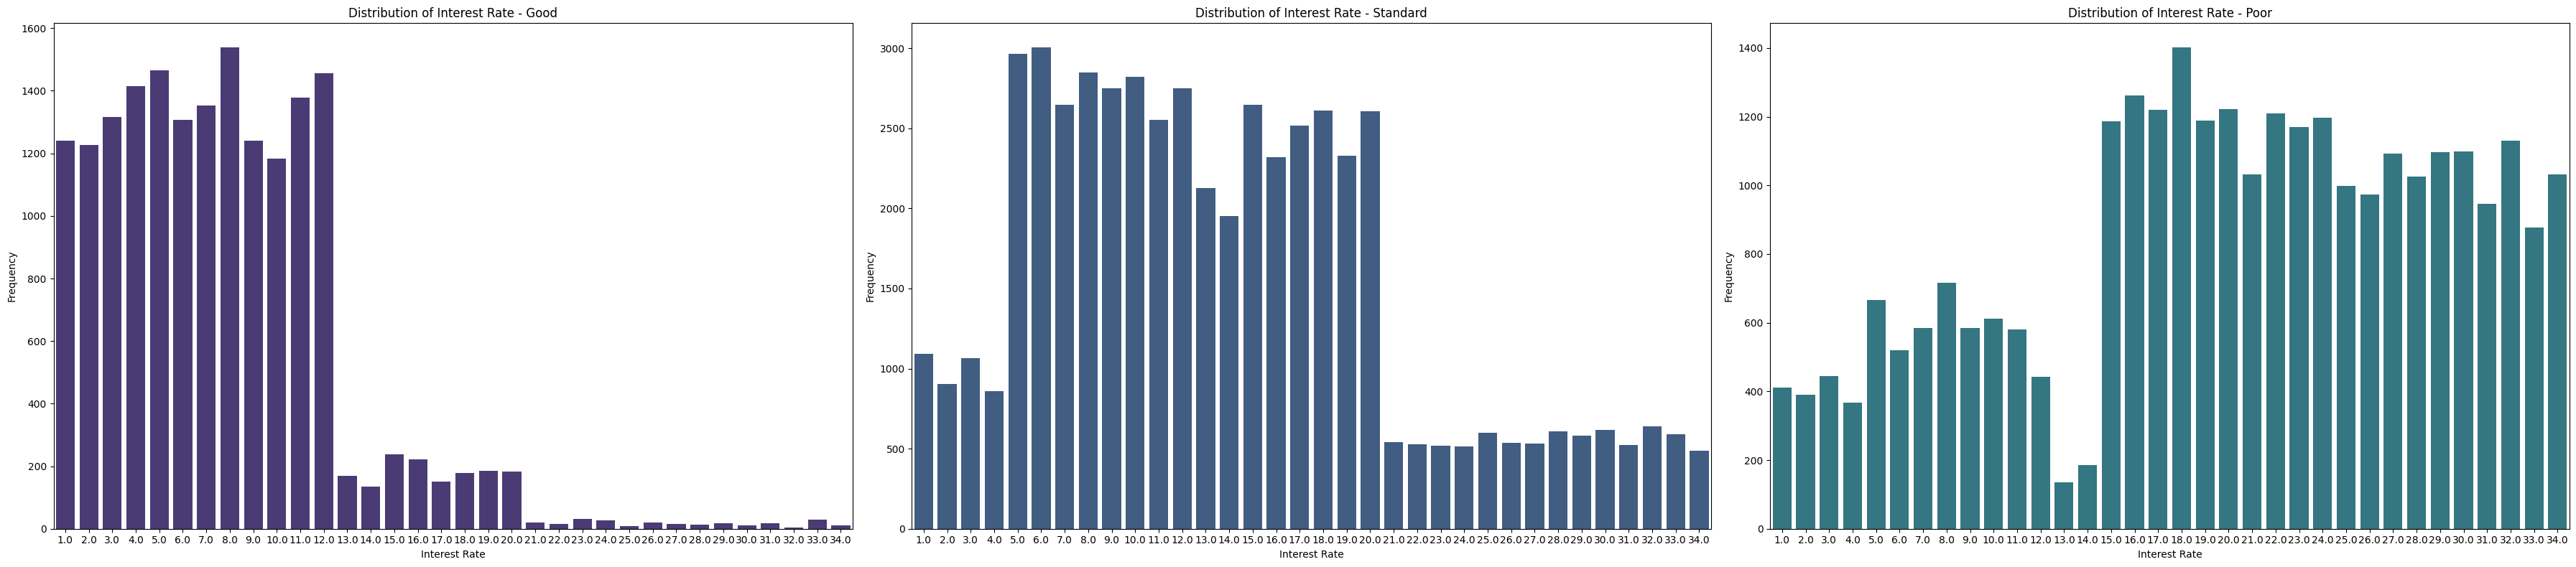

In [ ]:
plt.figure(figsize=(36, 8))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Interest_Rate'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Interest_Rate'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Interest Rate - {category}')
    plt.xlabel('Interest Rate')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Loans by Credit Score Category

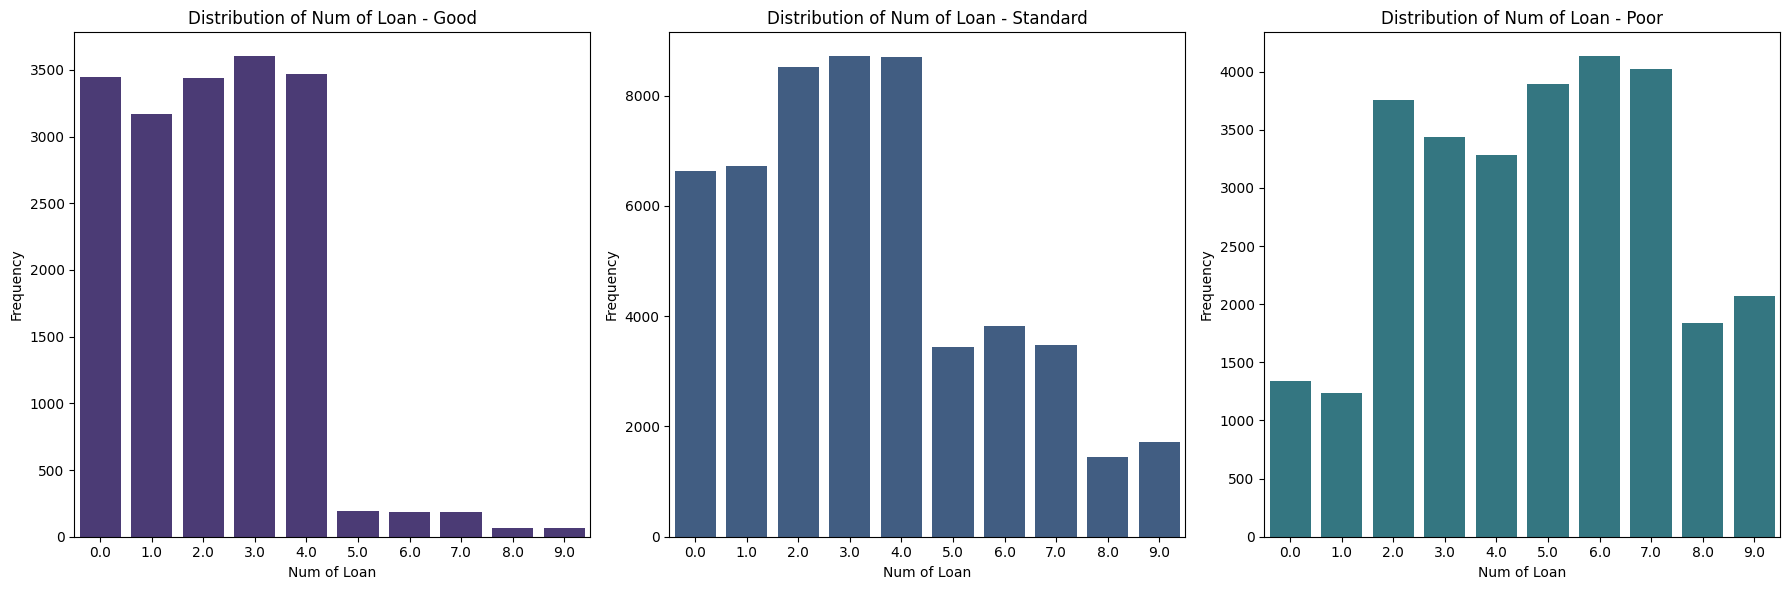

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_of_Loan'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_of_Loan'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Loan - {category}')
    plt.xlabel('Num of Loan')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Delay from due date by Credit Score Category

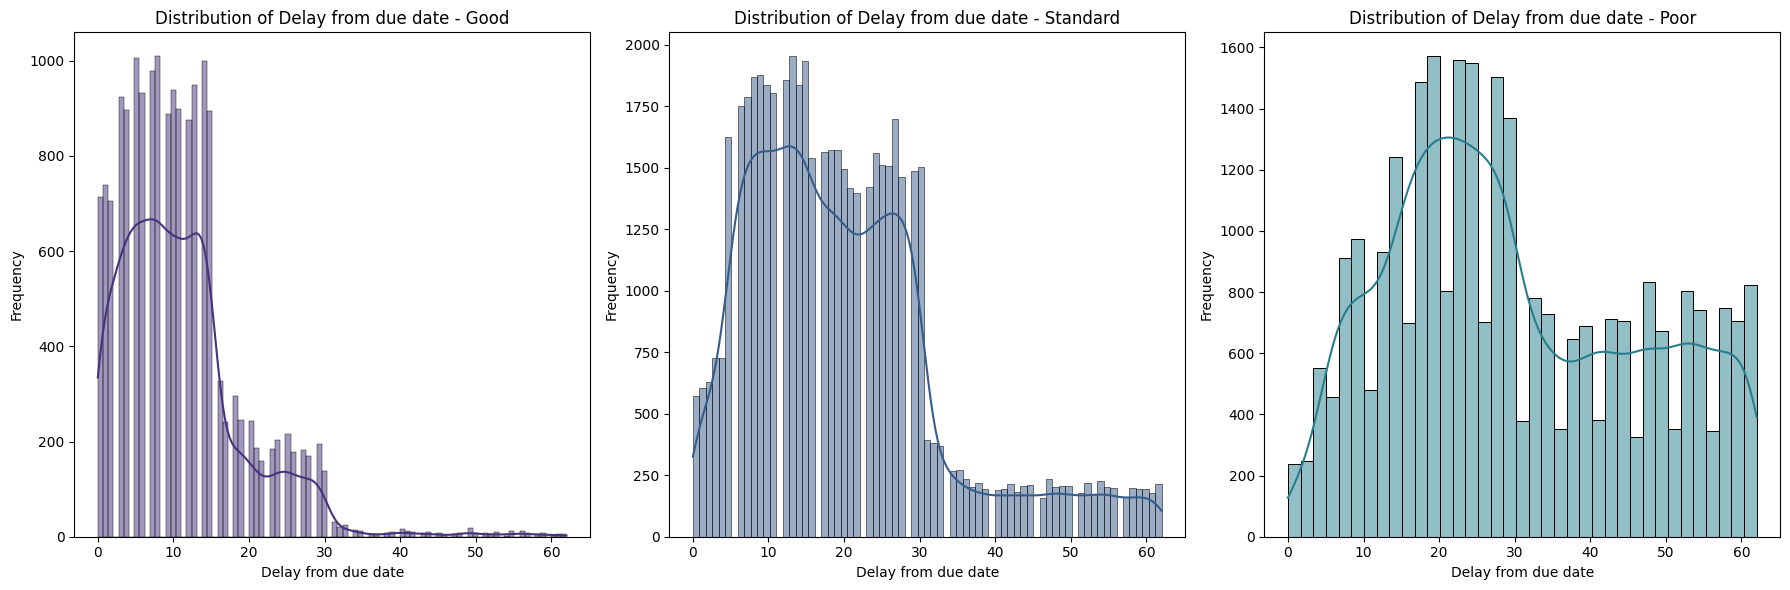

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Delay_from_due_date'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Delay from due date - {category}')
    plt.xlabel('Delay from due date')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Delayed Payment by Credit Score Category

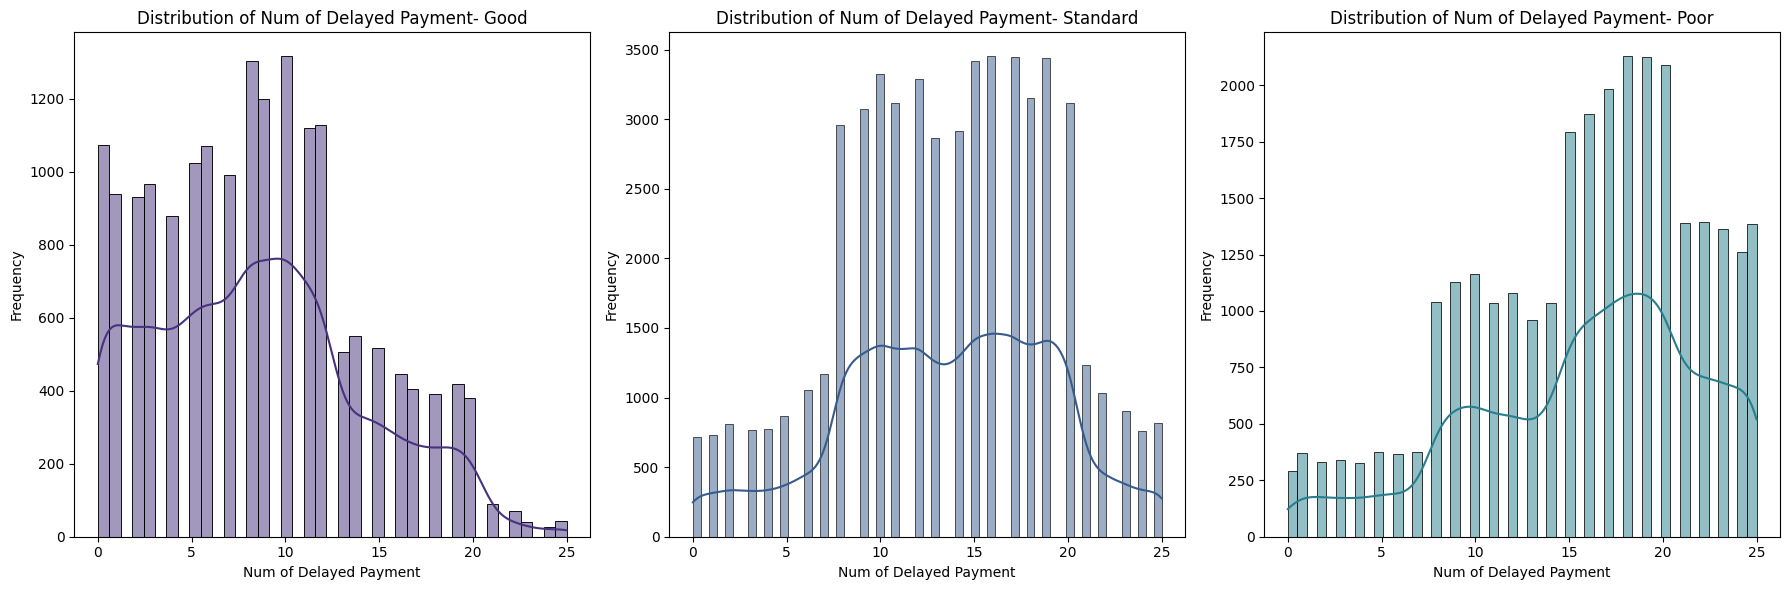

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Num_of_Delayed_Payment'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Delayed Payment- {category}')
    plt.xlabel('Num of Delayed Payment')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Credit Inquiries by Credit Score Category

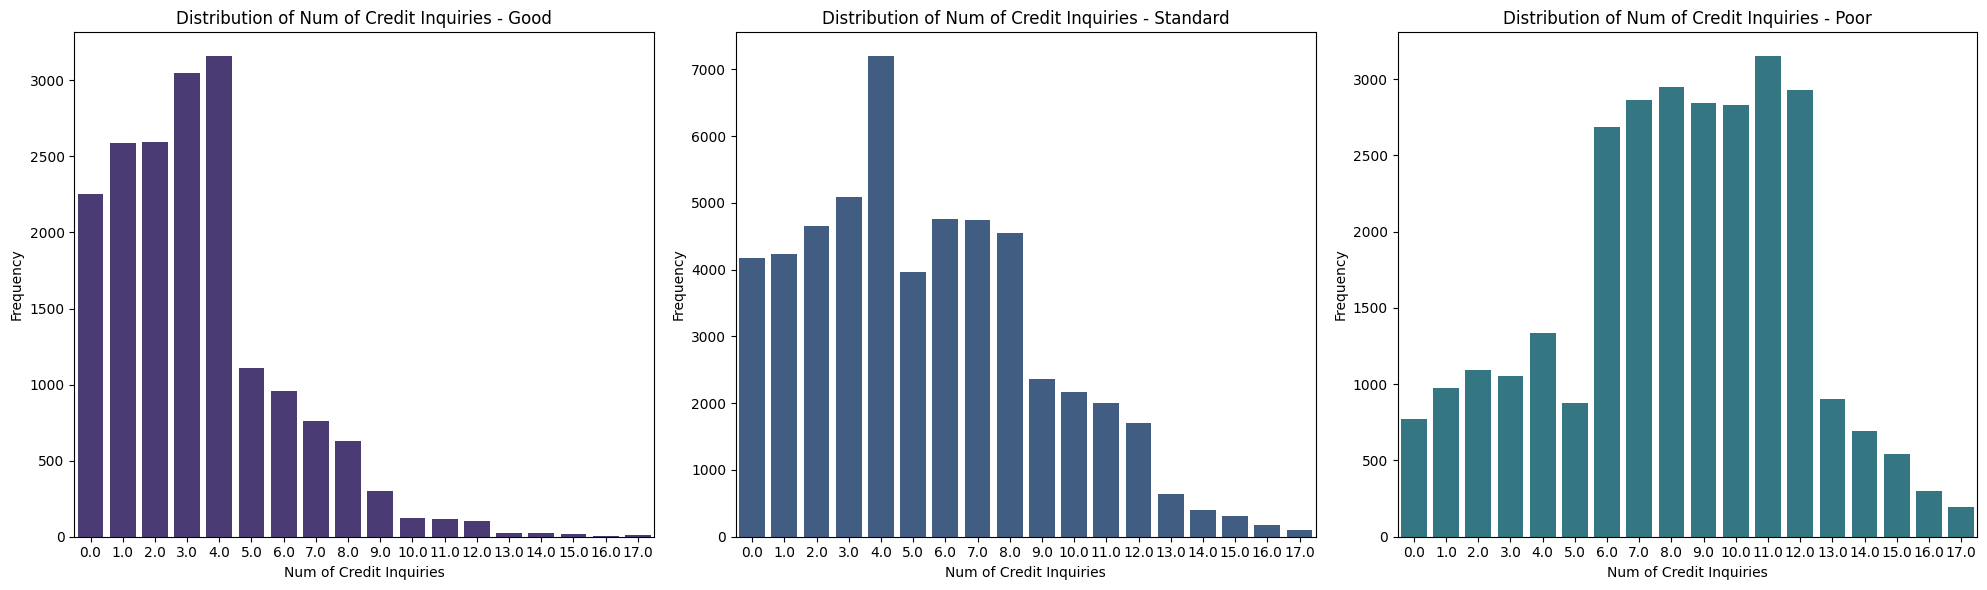

In [ ]:
plt.figure(figsize=(20, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_Credit_Inquiries'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_Credit_Inquiries'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Credit Inquiries - {category}')
    plt.xlabel('Num of Credit Inquiries')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Outstanding Debt by Credit Score Category

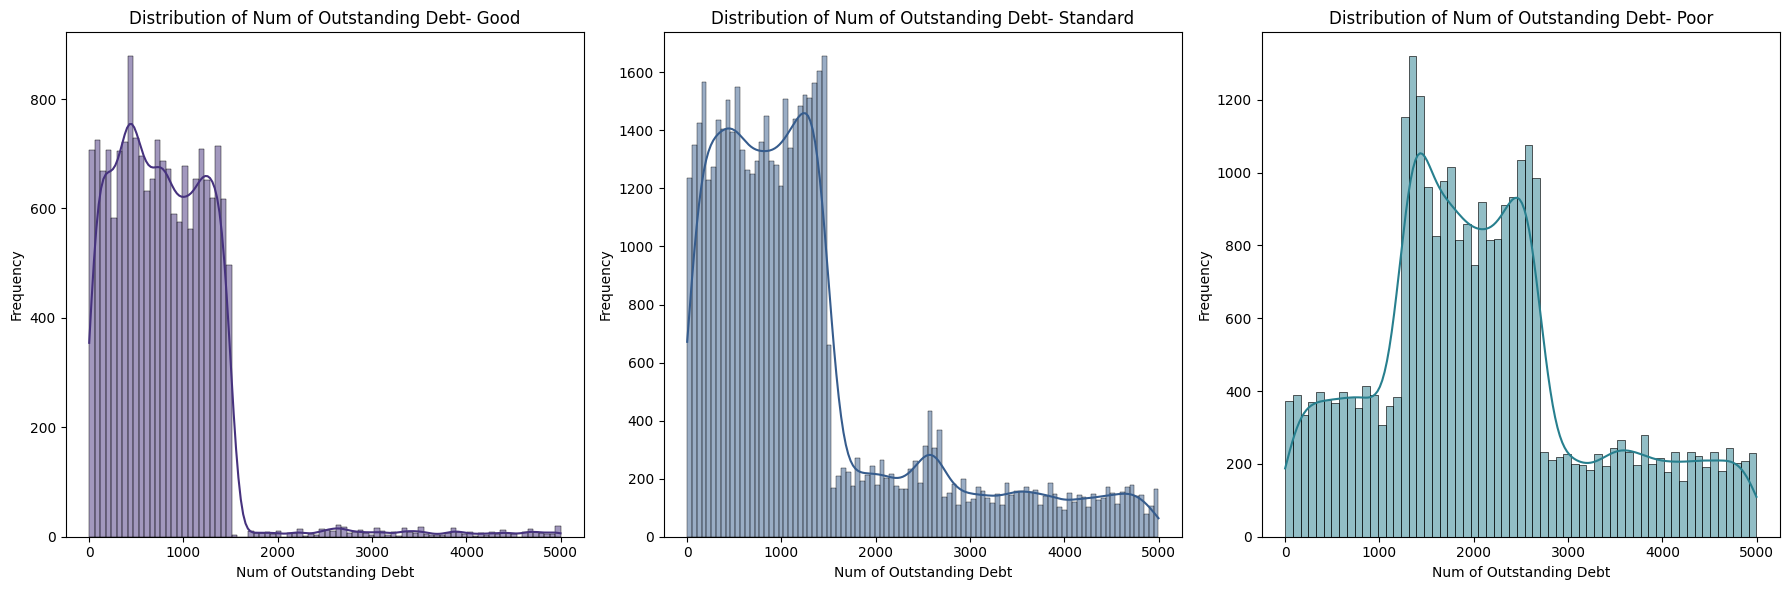

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Outstanding_Debt'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Outstanding Debt- {category}')
    plt.xlabel('Num of Outstanding Debt')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Credit History Age by Credit Score Category

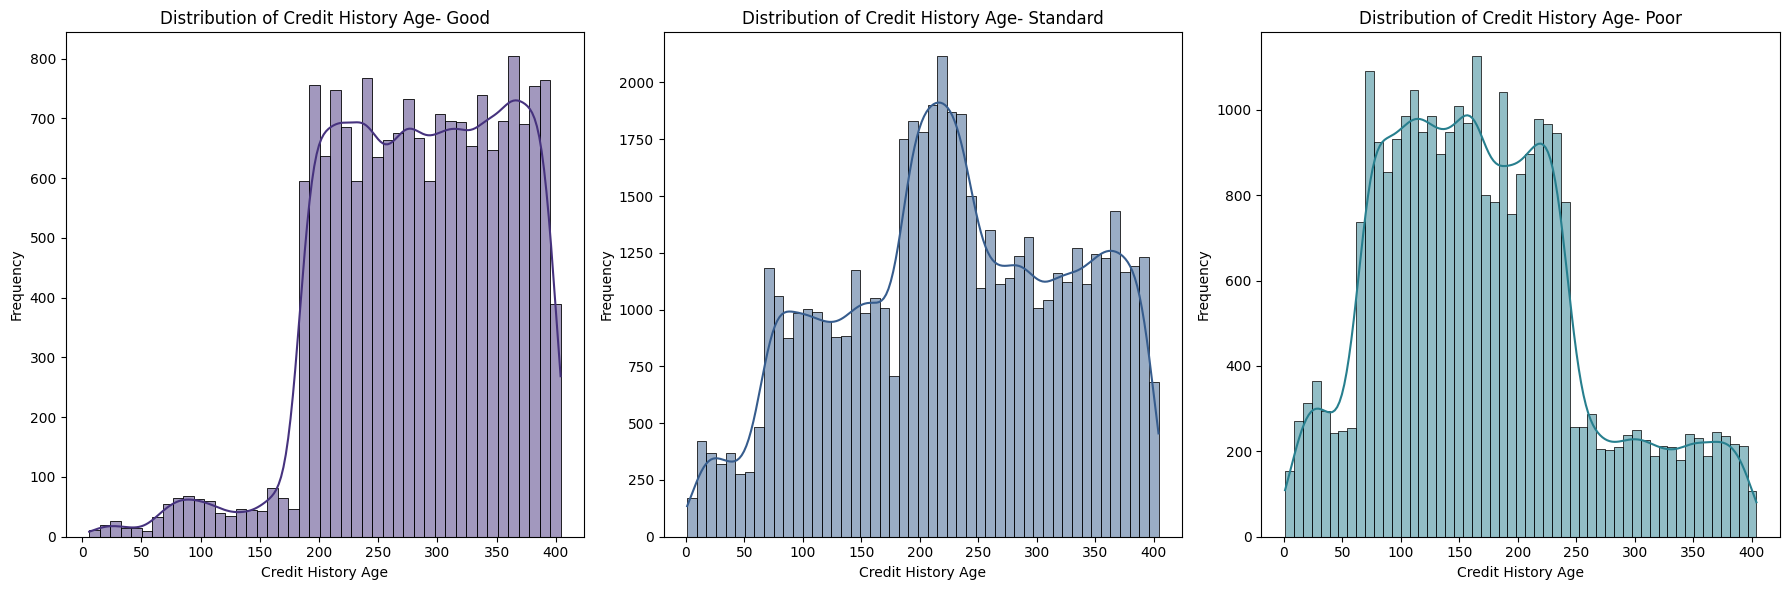

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Credit_History_Age'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Credit History Age- {category}')
    plt.xlabel('Credit History Age')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Total EMI per month by Credit Score Category

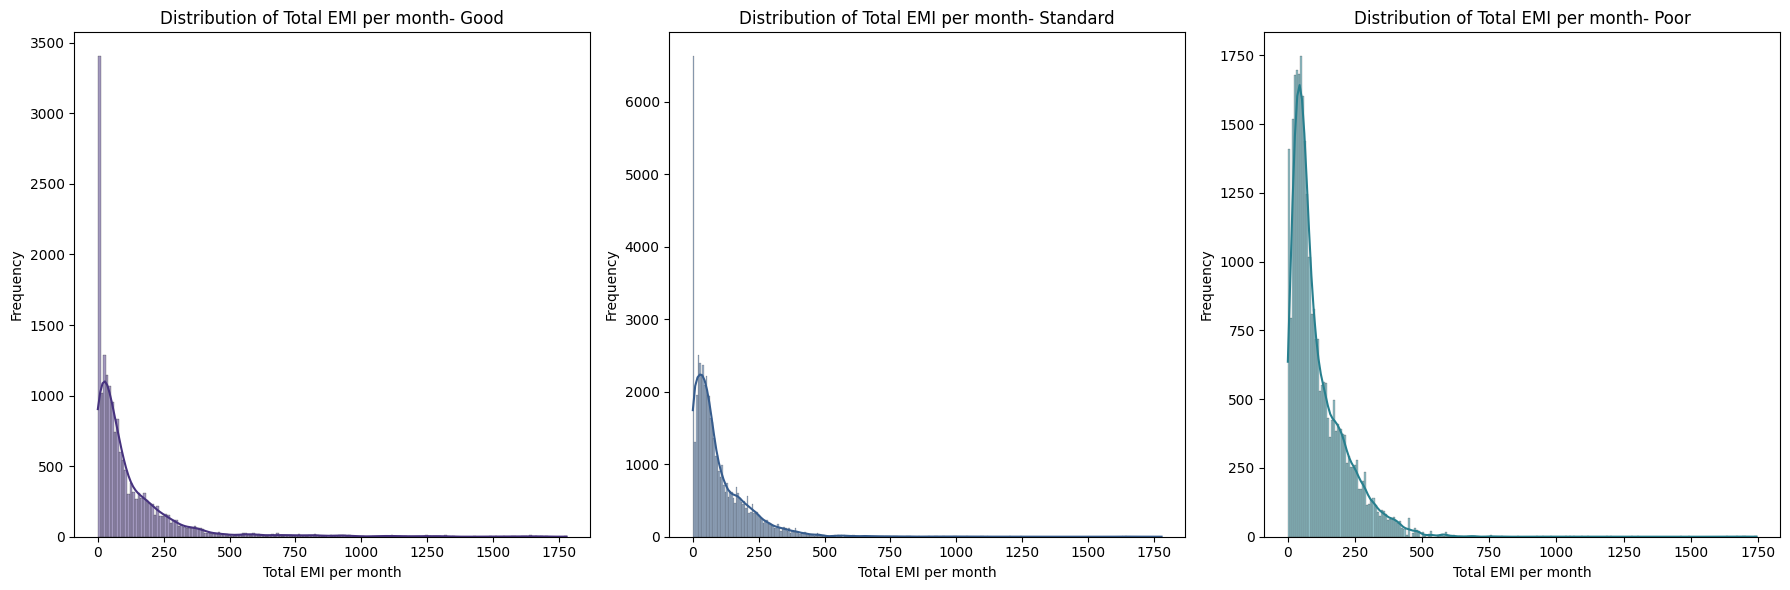

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Total_EMI_per_month'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Total EMI per month- {category}')
    plt.xlabel('Total EMI per month')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Amount invested monthly by Credit Score Category

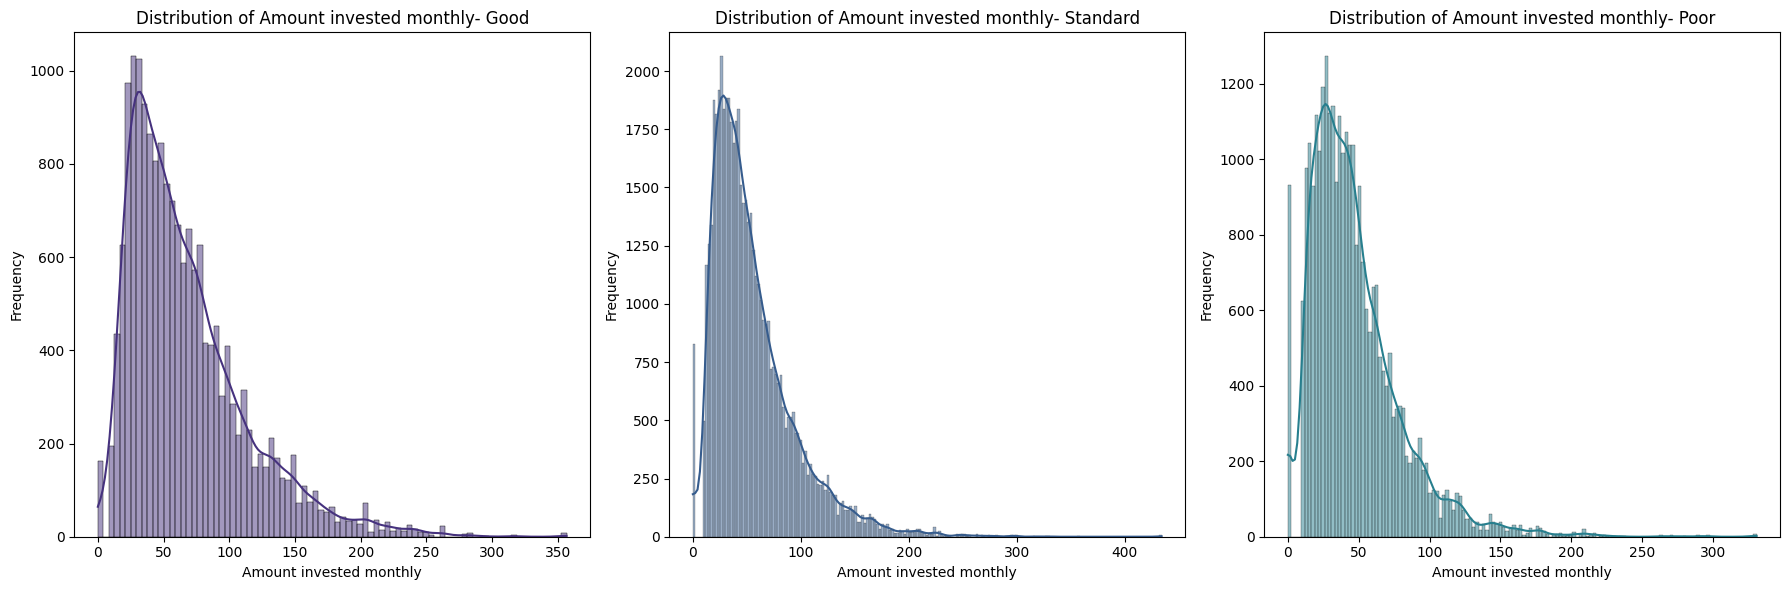

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Amount_invested_monthly'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Amount invested monthly- {category}')
    plt.xlabel('Amount invested monthly')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Monthly Balance by Credit Score Category

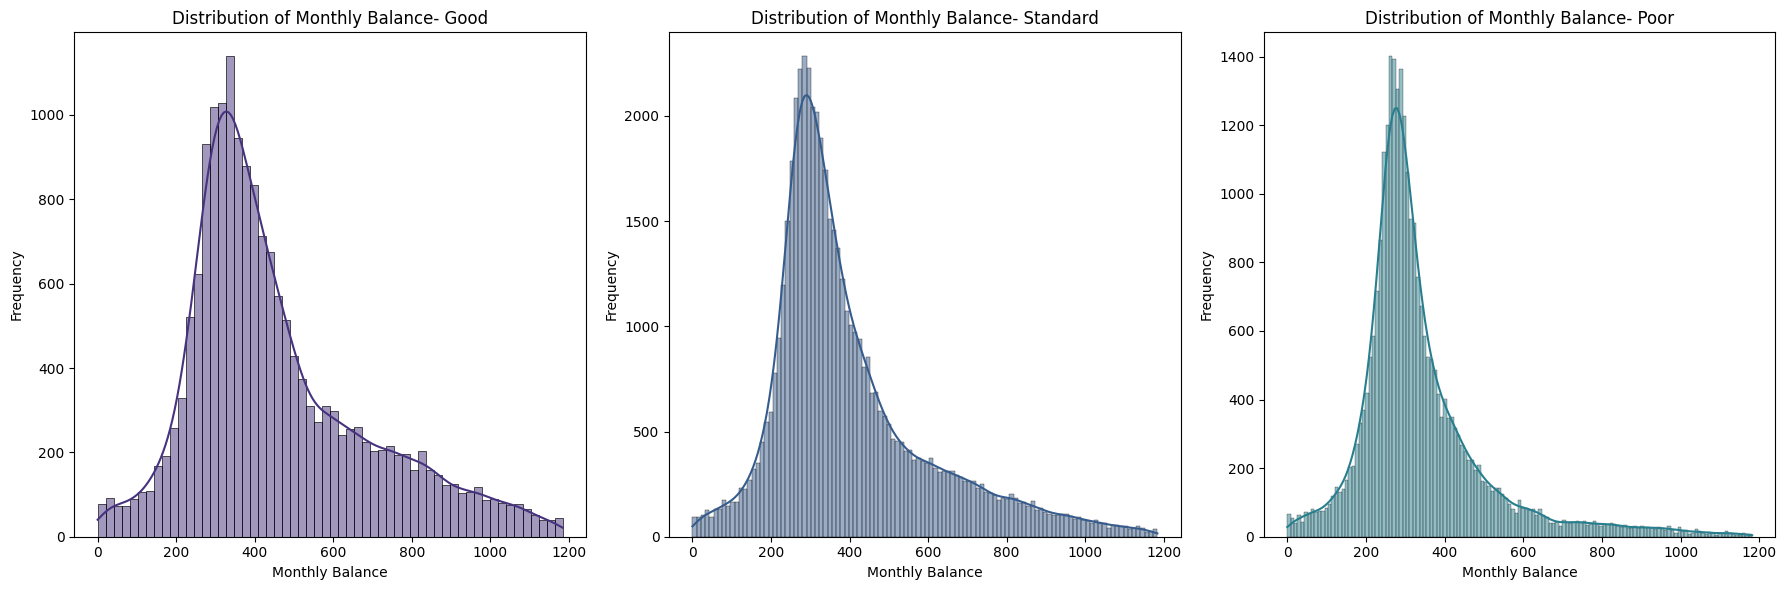

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Monthly_Balance'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Monthly Balance- {category}')
    plt.xlabel('Monthly Balance')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Payment Behaviour by Credit Score Category

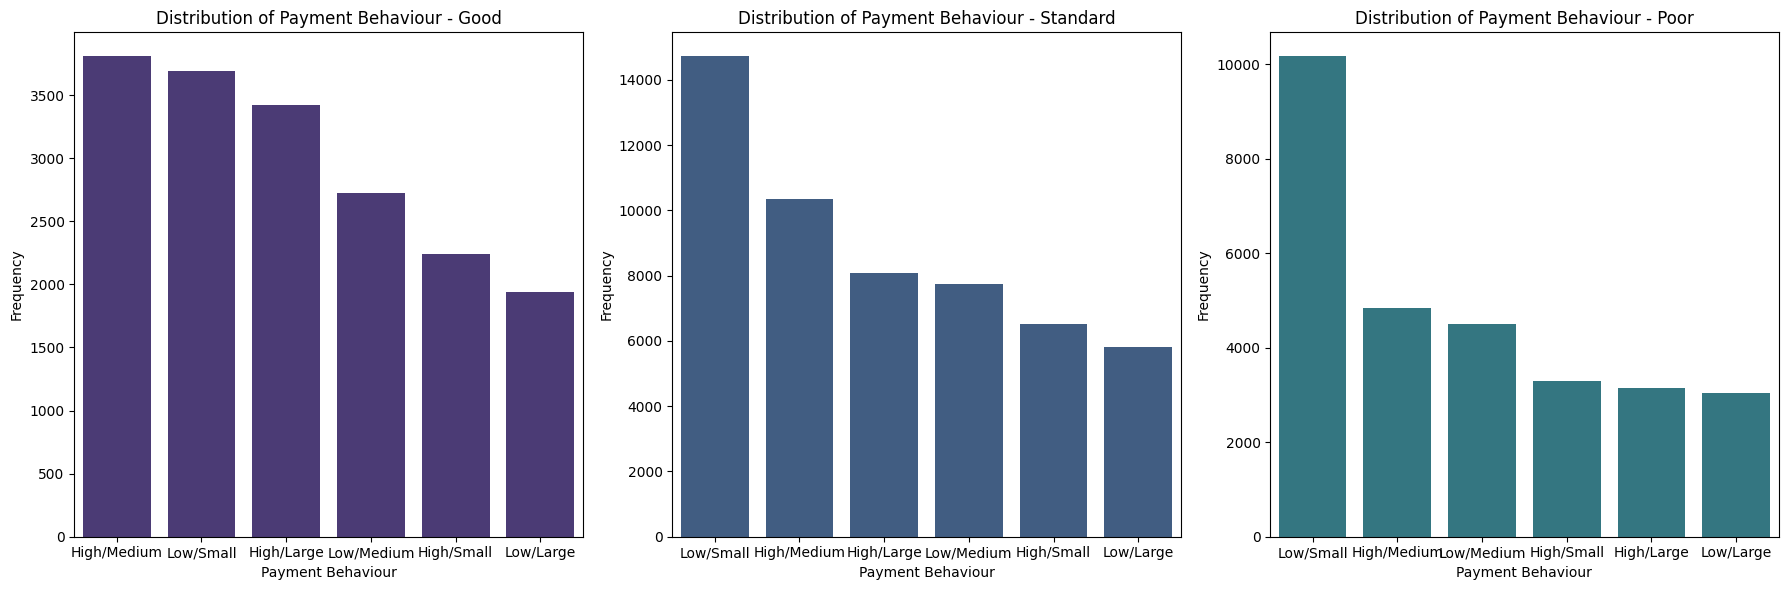

In [ ]:
payment_behaviour_mapping = {
    'Low_spent_Small_value_payments': 'Low/Small',
    'High_spent_Medium_value_payments': 'High/Medium',
    'Low_spent_Medium_value_payments': 'Low/Medium',
    'High_spent_Large_value_payments': 'High/Large',
    'High_spent_Small_value_payments': 'High/Small',
    'Low_spent_Large_value_payments': 'Low/Large'
}

data['Payment_Behaviour'] = data['Payment_Behaviour'].replace(payment_behaviour_mapping)

plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(
        x=data[data['Credit_Score'] == category]['Payment_Behaviour'].value_counts().index,
        y=data[data['Credit_Score'] == category]['Payment_Behaviour'].value_counts().values,
        color=sns.color_palette("viridis")[i]
    )
    plt.title(f'Distribution of Payment Behaviour - {category}')
    plt.xlabel('Payment Behaviour')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature Engineering

## Create a new feature Age_Income_Interaction to understand the interaction between Age and Income


In [ ]:
data['Age_Income_Interaction'] = data['Age'] * data['Annual_Income']

## Create new features Debt_Income_Ratio and Credit_Utilization_per_Card


In [ ]:
data['Debt_Income_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']
data['Credit_Utilization_per_Card'] = np.where(
    data['Num_Credit_Card'] == 0,
    0,
    data['Credit_Utilization_Ratio'] / data['Num_Credit_Card']
)

In [ ]:
data.sample(10)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Age_Income_Interaction,Debt_Income_Ratio,Credit_Utilization_per_Card
9239,19489,6581,8,Jan Strupczewskip,52.0,331731353.0,Mechanic,11855.820,943.985000,6.0,...,214.0,Yes,5.711417,29.290398,Low/Small,298.632850,Poor,616502.640,0.062026,5.542072
39359,64669,49174,8,Slaterq,34.0,850472557.0,Entrepreneur,44793.340,3677.778333,0.0,...,309.0,No,0.000000,63.280515,High/Medium,507.740114,Good,1522973.560,0.013077,4.802412
7349,16655,7467,6,Clarke,32.0,115929660.0,Accountant,26217.460,1930.788333,8.0,...,326.0,Yes,27.045547,25.309261,High/Medium,339.248072,Standard,838958.720,0.043308,11.386650
48731,78729,20201,4,Dayw,21.0,603956149.0,Media_Manager,35329.840,2819.153333,4.0,...,365.0,No,15.141197,41.415555,High/Medium,465.358582,Good,741926.640,0.025428,12.569857
44772,72790,1079,5,Ross Kerberz,48.0,69627151.0,Developer,105816.450,8977.037500,4.0,...,246.0,Yes,79.495972,61.500767,Low/Small,304.370787,Standard,5079189.600,0.012684,11.766077
34745,57751,7893,2,Parra-Bernalo,31.0,25323903.0,Teacher,18965.350,1317.445833,10.0,...,90.0,Yes,43.936110,55.794111,Low/Small,287.644473,Poor,587925.850,0.078607,3.402868
69857,110419,20119,2,Danielh,50.0,215672608.0,Media_Manager,82929.960,6872.830000,1.0,...,300.0,No,68.516869,63.430880,High/Large,793.159524,Poor,4146498.000,0.008870,5.580404
58051,92709,50771,4,Harichf,41.0,30581857.0,Architect,21380.065,2005.672083,2.0,...,287.0,NM,30.570849,57.753708,Low/Medium,383.985603,Standard,876582.665,0.035738,18.397045
88510,138396,6568,7,Victoriav,43.0,738507769.0,Musician,30683.420,2222.806019,4.0,...,316.0,NM,222.030104,41.314311,Low/Large,288.766285,Standard,1319387.060,0.000236,6.146796
85192,133422,19499,1,Jessica Wohlr,45.0,594386492.0,Doctor,20945.380,1619.448333,3.0,...,177.0,Yes,50.424252,25.912195,Low/Small,306.627914,Standard,942542.100,0.066666,6.023784


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           100000 non-null  int64  
 1   Customer_ID                  100000 non-null  int64  
 2   Month                        100000 non-null  int64  
 3   Name                         100000 non-null  object 
 4   Age                          100000 non-null  float64
 5   SSN                          100000 non-null  float64
 6   Occupation                   100000 non-null  object 
 7   Annual_Income                100000 non-null  float64
 8   Monthly_Inhand_Salary        100000 non-null  float64
 9   Num_Bank_Accounts            100000 non-null  float64
 10  Num_Credit_Card              100000 non-null  float64
 11  Interest_Rate                100000 non-null  float64
 12  Num_of_Loan                  100000 non-null  float64
 13  

In [ ]:
data.describe()

,ID,Customer_ID,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Age_Income_Interaction,Debt_Income_Ratio,Credit_Utilization_per_Card
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,80631.500000,25982.666640,4.500000,33.316340,5.004617e+08,50505.123449,4197.270835,5.368820,5.533570,14.53208,...,5.798250,1426.220376,32.285173,221.220460,107.699208,55.101315,392.697586,1.720380e+06,0.060657,7.162955
std,43301.486619,14340.543051,2.291299,10.764812,2.908267e+08,38299.422093,3186.432497,2.593314,2.067098,8.74133,...,3.867826,1155.129026,5.116875,99.680716,132.267056,39.006932,201.652719,1.531718e+06,0.087425,4.899933
min,5634.000000,1006.000000,1.000000,14.000000,8.134900e+04,7005.930000,303.645417,0.000000,0.000000,1.00000,...,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760,9.808302e+04,0.000003,0.000000
25%,43132.750000,13664.500000,2.750000,24.000000,2.451686e+08,19342.972500,1626.594167,3.000000,4.000000,7.00000,...,3.000000,566.072500,28.052567,144.000000,29.268886,27.959111,267.615983,6.192719e+05,0.009572,4.515798
50%,80631.500000,25777.000000,4.500000,33.000000,5.006886e+08,36999.705000,3095.905000,5.000000,5.000000,13.00000,...,5.000000,1166.155000,32.305784,219.000000,66.462304,45.156550,333.865366,1.201393e+06,0.028250,5.914898
75%,118130.250000,38385.000000,6.250000,42.000000,7.560027e+08,71683.470000,5957.715000,7.000000,7.000000,20.00000,...,8.000000,1945.962500,36.496663,302.000000,147.392573,71.295797,463.215683,2.319293e+06,0.069716,8.155190
max,155629.000000,50999.000000,8.000000,56.000000,9.999934e+08,179987.280000,15204.633333,11.000000,11.000000,34.00000,...,17.000000,4998.070000,50.000000,404.000000,1779.103254,434.191089,1183.930696,1.001246e+07,0.683252,49.522324


In [ ]:
data.nunique()

,0
ID,100000
Customer_ID,12500
Month,8
Name,10128
Age,43
SSN,12500
Occupation,15
Annual_Income,12488
Monthly_Inhand_Salary,13241
Num_Bank_Accounts,12


## Check the distriution of new columns

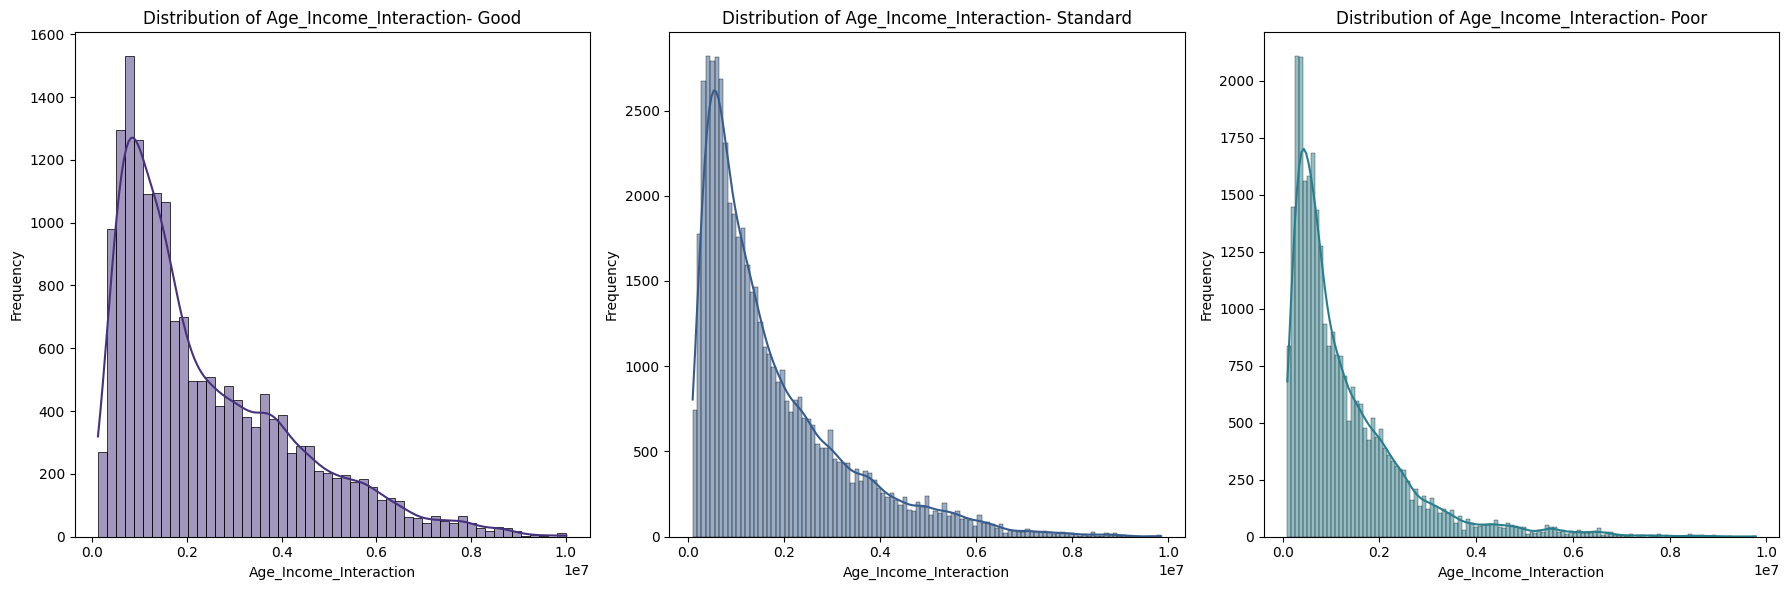

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Age_Income_Interaction'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Age_Income_Interaction- {category}')
    plt.xlabel('Age_Income_Interaction')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

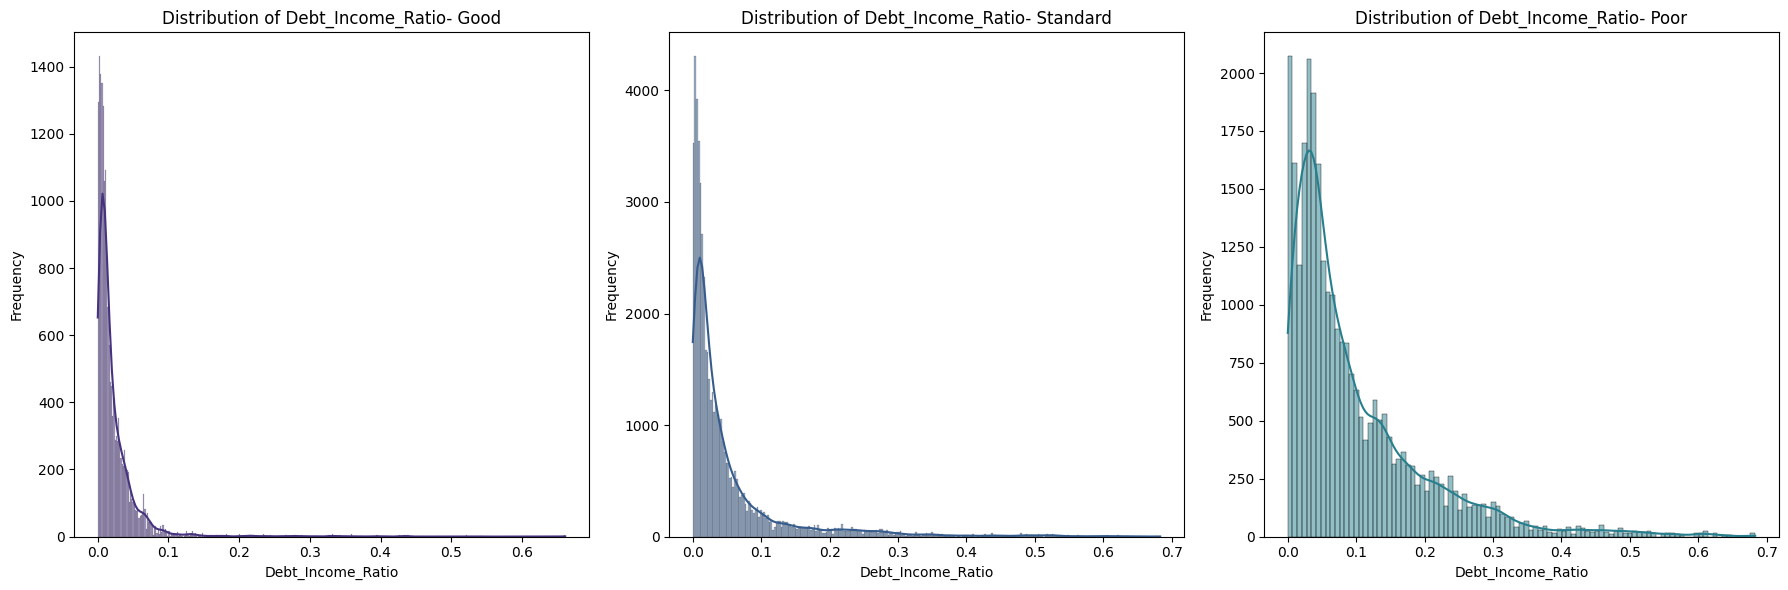

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Debt_Income_Ratio'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Debt_Income_Ratio- {category}')
    plt.xlabel('Debt_Income_Ratio')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

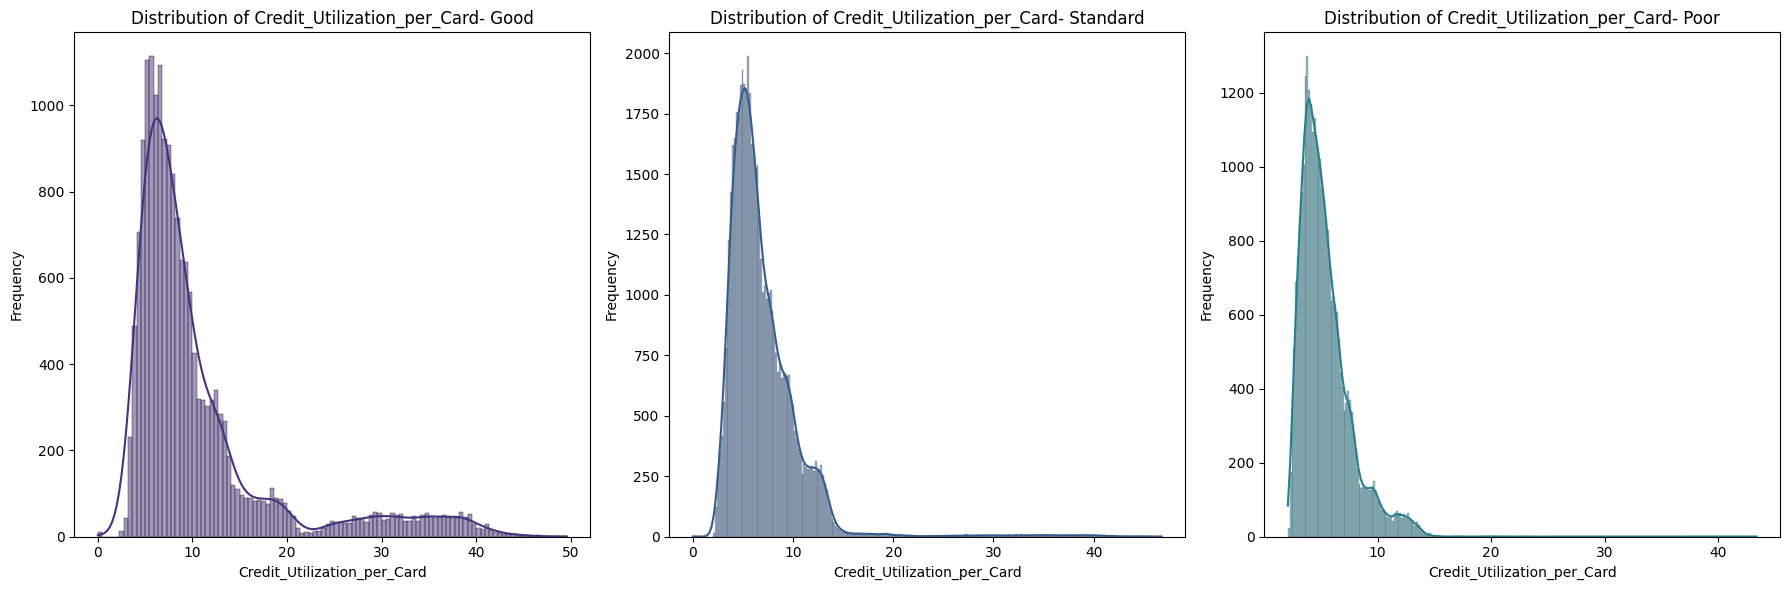

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Credit_Utilization_per_Card'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Credit_Utilization_per_Card- {category}')
    plt.xlabel('Credit_Utilization_per_Card')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Drop unnecessary columns

In [ ]:
data.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan', 'Changed_Credit_Limit',
           'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Monthly_Balance'], axis=1, inplace=True)

In [ ]:
data.sample(10)

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Payment_Behaviour,Credit_Score,Age_Income_Interaction,Debt_Income_Ratio,Credit_Utilization_per_Card
47646,33.0,Engineer,15717.275,1270.772917,1.0,5.0,8.0,1.0,7.0,11.0,...,Good,1020.27,376.0,NM,152.181475,High/Large,Good,518670.075,0.064914,7.832505
57504,44.0,Mechanic,53860.980,4260.415000,4.0,7.0,15.0,0.0,17.0,8.0,...,Standard,1356.10,188.0,NM,0.000000,Low/Large,Standard,2369883.120,0.025178,3.552786
88008,19.0,Accountant,60174.930,4912.577500,9.0,8.0,26.0,5.0,28.0,19.0,...,Bad,3015.47,4.0,Yes,135.894440,High/Small,Poor,1143323.670,0.050112,4.988655
18236,35.0,Entrepreneur,119433.420,10099.785000,0.0,3.0,2.0,3.0,15.0,12.0,...,Good,945.30,314.0,No,256.343745,Low/Small,Good,4180169.700,0.007915,9.867114
85243,25.0,Teacher,9620.965,782.747083,10.0,7.0,24.0,2.0,59.0,16.0,...,Bad,1355.28,142.0,Yes,9.675866,Low/Small,Poor,240524.125,0.140867,4.973591
73460,34.0,Developer,22311.990,1577.332500,4.0,5.0,4.0,3.0,11.0,2.0,...,Good,104.09,351.0,NM,38.235270,Low/Small,Standard,758607.660,0.004665,4.587987
60042,32.0,Developer,48494.550,4155.212500,9.0,9.0,25.0,8.0,31.0,23.0,...,Bad,1891.02,99.0,Yes,311.400009,Low/Small,Poor,1551825.600,0.038994,3.124435
32505,34.0,Developer,101718.630,8457.552500,3.0,3.0,12.0,0.0,12.0,8.0,...,Good,754.58,310.0,No,0.000000,High/Large,Good,3458433.420,0.007418,12.566679
31541,32.0,Entrepreneur,14214.460,898.538333,4.0,7.0,19.0,4.0,12.0,6.0,...,Standard,908.46,195.0,Yes,41.886166,Low/Small,Standard,454862.720,0.063911,3.461145
31381,38.0,Musician,57035.580,4823.965000,3.0,7.0,12.0,0.0,24.0,12.0,...,Standard,550.23,259.0,No,0.000000,High/Small,Standard,2167352.040,0.009647,5.696313


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          100000 non-null  float64
 1   Occupation                   100000 non-null  object 
 2   Annual_Income                100000 non-null  float64
 3   Monthly_Inhand_Salary        100000 non-null  float64
 4   Num_Bank_Accounts            100000 non-null  float64
 5   Num_Credit_Card              100000 non-null  float64
 6   Interest_Rate                100000 non-null  float64
 7   Num_of_Loan                  100000 non-null  float64
 8   Delay_from_due_date          100000 non-null  float64
 9   Num_of_Delayed_Payment       100000 non-null  float64
 10  Num_Credit_Inquiries         100000 non-null  float64
 11  Credit_Mix                   100000 non-null  object 
 12  Outstanding_Debt             100000 non-null  float64
 13  

# Association

In [ ]:
num_cols = data.select_dtypes(include=['float64']).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Credit_Utilization_per_Card']
Categorical Columns: ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']


## Cramer's V

In [ ]:
crv = data.apply(lambda x: x.astype("category") if x.dtype == "O" or x.dtype == "bool" else x)
cramers_v = am.CramersV(crv)

cfit = cramers_v.fit().round(2)
cfit

,Occupation,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
Occupation,1.00,0.03,0.02,0.01,0.03
Credit_Mix,0.03,1.00,0.54,0.09,0.45
Payment_of_Min_Amount,0.02,0.54,1.00,0.08,0.31
Payment_Behaviour,0.01,0.09,0.08,1.00,0.09
Credit_Score,0.03,0.45,0.31,0.09,1.00


**Payment_Behaviour** and **Occupation** have very less association with **Credit_Score**.

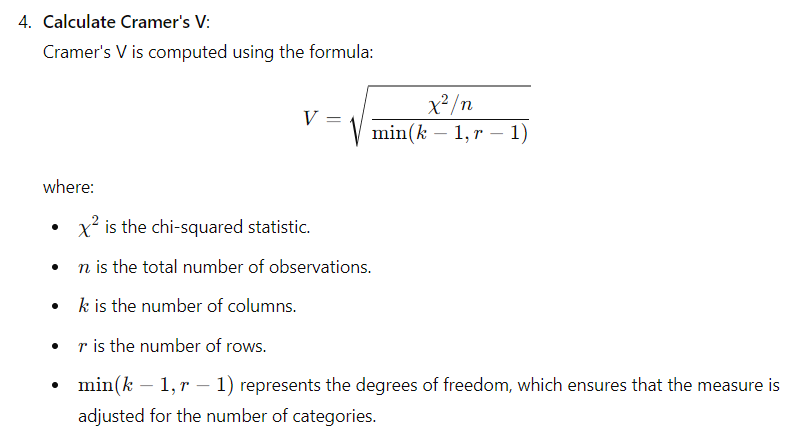

## Correlation Matrix

In [ ]:
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2}))

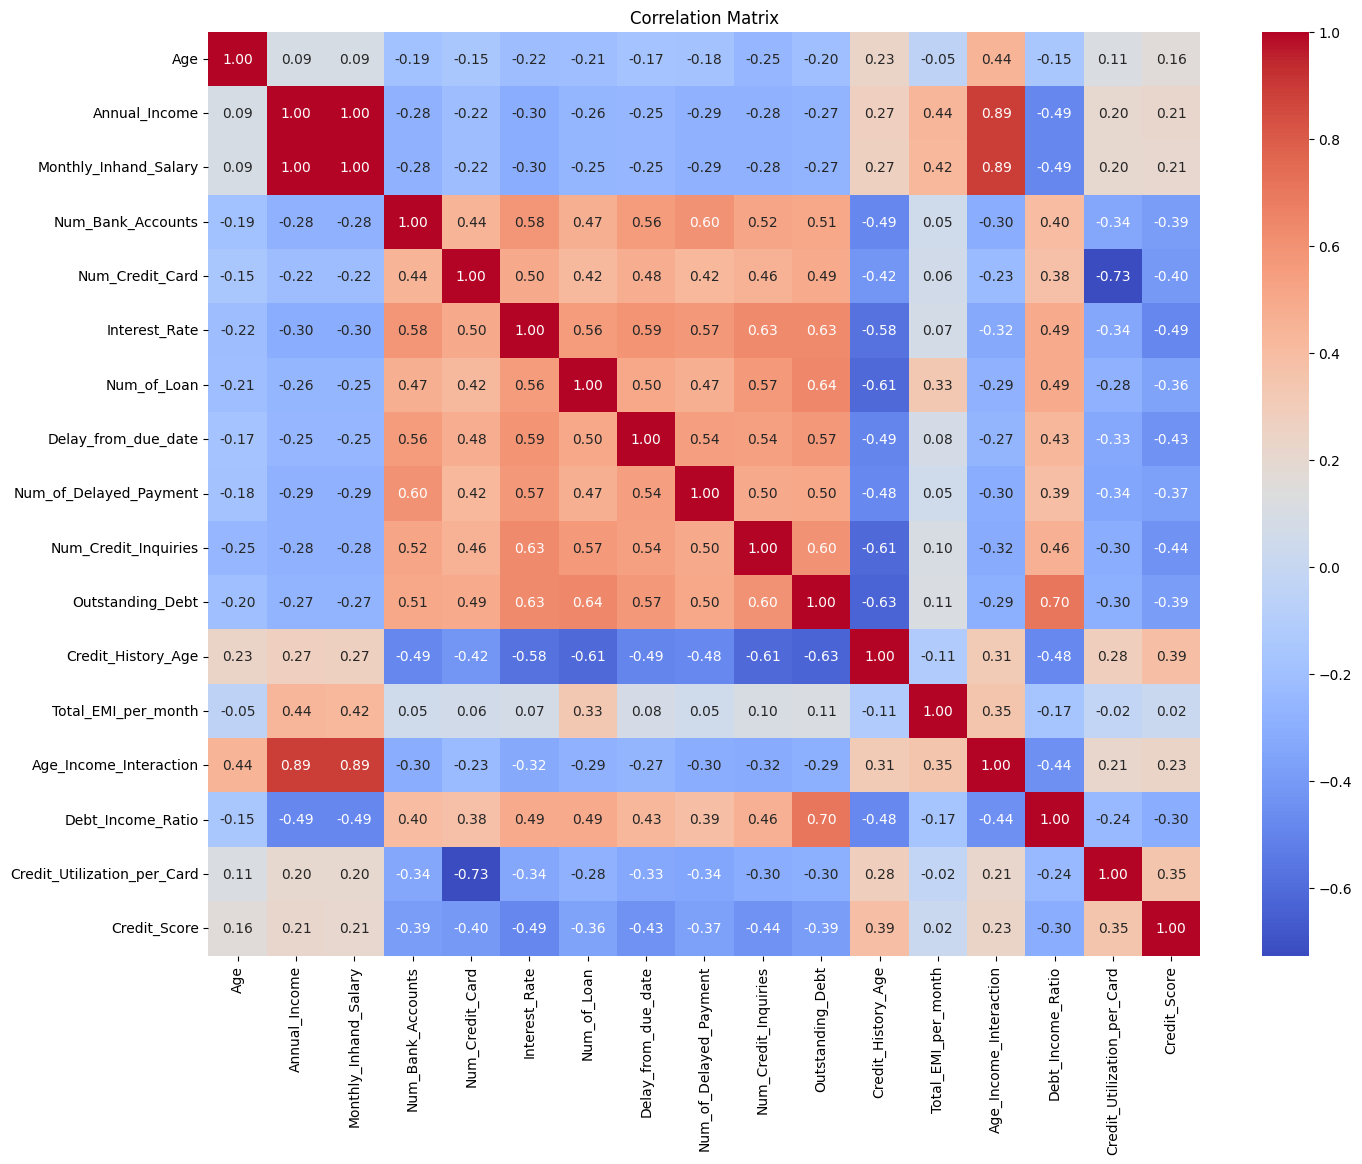

In [ ]:
corr_matrix = data[num_cols + ['Credit_Score']].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**High Multicollinearity between some features.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          100000 non-null  float64
 1   Occupation                   100000 non-null  object 
 2   Annual_Income                100000 non-null  float64
 3   Monthly_Inhand_Salary        100000 non-null  float64
 4   Num_Bank_Accounts            100000 non-null  float64
 5   Num_Credit_Card              100000 non-null  float64
 6   Interest_Rate                100000 non-null  float64
 7   Num_of_Loan                  100000 non-null  float64
 8   Delay_from_due_date          100000 non-null  float64
 9   Num_of_Delayed_Payment       100000 non-null  float64
 10  Num_Credit_Inquiries         100000 non-null  float64
 11  Credit_Mix                   100000 non-null  object 
 12  Outstanding_Debt             100000 non-null  float64
 13  

## Handling Multicollinearity by taking subset of features

In [ ]:
num_cols = data.select_dtypes(include=['float64']).columns.tolist()

X = data.drop(columns=['Credit_Score'])
Y = data['Credit_Score']

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df = calculate_vif(X[num_cols])
vif_df_sorted = vif_df.sort_values(by='VIF', ascending=False)
print(vif_df_sorted)

                        Feature         VIF
1                 Annual_Income  886.937505
2         Monthly_Inhand_Salary  841.121507
13       Age_Income_Interaction   24.723406
0                           Age   21.108019
4               Num_Credit_Card   17.152284
8        Num_of_Delayed_Payment   10.374584
3             Num_Bank_Accounts   10.332463
11           Credit_History_Age    9.725081
5                 Interest_Rate    9.134004
10             Outstanding_Debt    8.508629
6                   Num_of_Loan    7.794483
9          Num_Credit_Inquiries    6.974930
7           Delay_from_due_date    5.993570
15  Credit_Utilization_per_Card    5.098279
14            Debt_Income_Ratio    3.853875
12          Total_EMI_per_month    3.283392


In [ ]:
num_cols = [col for col in num_cols if col not in ['Annual_Income', 'Monthly_Inhand_Salary']]

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df_reduced = calculate_vif(X[num_cols])

vif_df_reduced_sorted = vif_df_reduced.sort_values(by='VIF', ascending=False)
print(vif_df_reduced_sorted)

                        Feature        VIF
2               Num_Credit_Card  15.506946
0                           Age  12.531232
6        Num_of_Delayed_Payment  10.317348
1             Num_Bank_Accounts  10.301341
3                 Interest_Rate   9.132118
9            Credit_History_Age   8.588978
8              Outstanding_Debt   8.428893
4                   Num_of_Loan   7.570229
7          Num_Credit_Inquiries   6.954479
5           Delay_from_due_date   5.990285
13  Credit_Utilization_per_Card   4.522251
11       Age_Income_Interaction   4.449548
12            Debt_Income_Ratio   3.699814
10          Total_EMI_per_month   2.786733


In [ ]:
data.drop(['Annual_Income', 'Monthly_Inhand_Salary'], axis=1, inplace=True)

# Split the dataset

In [ ]:
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

In [ ]:
X.head()

,Age,Occupation,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Payment_Behaviour,Age_Income_Interaction,Debt_Income_Ratio,Credit_Utilization_per_Card
0,23.0,Scientist,3.0,4.0,3.0,4.0,3.0,7.0,4.0,Good,809.98,265.0,No,49.574949,High/Small,439624.76,0.042376,6.705655
1,23.0,Scientist,3.0,4.0,3.0,4.0,3.0,4.0,4.0,Good,809.98,266.0,No,49.574949,Low/Large,439624.76,0.042376,7.986240
2,23.0,Scientist,3.0,4.0,3.0,4.0,3.0,7.0,4.0,Good,809.98,267.0,No,49.574949,Low/Medium,439624.76,0.042376,7.152338
3,23.0,Scientist,3.0,4.0,3.0,4.0,5.0,4.0,4.0,Good,809.98,268.0,No,49.574949,Low/Small,439624.76,0.042376,7.844465
4,23.0,Scientist,3.0,4.0,3.0,4.0,6.0,4.0,4.0,Good,809.98,269.0,No,49.574949,High/Medium,439624.76,0.042376,6.199337


In [ ]:
y.sample(5)

,Credit_Score
51286,1
67495,1
19253,1
76133,0
4839,1


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 18), (30000, 18), (70000,), (30000,))

# Encoding

## Target Encoding (Mean Encoding)

In [ ]:
X_train['Credit_Score'] = y_train

occupation_mean = X_train.groupby('Occupation')['Credit_Score'].mean()
payment_of_min_amount_mean = X_train.groupby('Payment_of_Min_Amount')['Credit_Score'].mean()
payment_behaviour_mean = X_train.groupby('Payment_Behaviour')['Credit_Score'].mean()

X_train['Occupation_encoded'] = X_train['Occupation'].map(occupation_mean)
X_train['Payment_of_Min_Amount_encoded'] = X_train['Payment_of_Min_Amount'].map(payment_of_min_amount_mean)
X_train['Payment_Behaviour_encoded'] = X_train['Payment_Behaviour'].map(payment_behaviour_mean)

X_train.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score'], axis=1, inplace=True)

X_test['Occupation_encoded'] = X_test['Occupation'].map(occupation_mean)
X_test['Payment_of_Min_Amount_encoded'] = X_test['Payment_of_Min_Amount'].map(payment_of_min_amount_mean)
X_test['Payment_Behaviour_encoded'] = X_test['Payment_Behaviour'].map(payment_behaviour_mean)

X_test.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour'], axis=1, inplace=True)

## Label Encoding

In [ ]:
credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2}

X_train['Credit_Mix'] = X_train['Credit_Mix'].map(credit_mix_map)
X_test['Credit_Mix'] = X_test['Credit_Mix'].map(credit_mix_map)

In [ ]:
X_train.sample(10)

,Age,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_History_Age,Total_EMI_per_month,Age_Income_Interaction,Debt_Income_Ratio,Credit_Utilization_per_Card,Occupation_encoded,Payment_of_Min_Amount_encoded,Payment_Behaviour_encoded
84854,18.0,9.0,10.0,30.0,9.0,30.0,13.0,12.0,0,2186.49,94.0,526.001223,1327183.20,0.029654,3.194274,0.876378,0.643626,1.016710
39446,20.0,3.0,4.0,5.0,1.0,4.0,2.0,0.0,2,1010.15,263.0,53.782285,2419725.00,0.008349,8.413165,0.899380,1.249870,0.895326
29597,16.0,9.0,9.0,31.0,8.0,62.0,19.0,12.0,0,4300.59,97.0,75.158902,224824.96,0.306058,3.773789,0.921447,0.643626,0.779096
41001,44.0,10.0,9.0,22.0,7.0,52.0,21.0,11.0,0,3886.64,29.0,34.010459,312268.66,0.547644,4.139903,0.866411,0.643626,0.885524
83689,21.0,5.0,6.0,5.0,6.0,15.0,16.0,8.0,1,2428.25,172.0,73.889782,390618.48,0.130545,4.341554,0.898243,0.896789,0.885524
96760,19.0,7.0,7.0,28.0,7.0,55.0,20.0,8.0,0,2150.59,179.0,161.747685,905189.07,0.045141,5.562127,0.866411,0.896789,0.909823
35692,47.0,5.0,4.0,10.0,2.0,11.0,12.0,0.0,1,39.75,187.0,22.966879,926169.78,0.002017,8.294794,0.911063,0.643626,0.895326
45084,38.0,5.0,7.0,21.0,4.0,15.0,16.0,12.0,1,2391.39,155.0,40.496882,744518.04,0.122056,3.883458,0.866411,0.643626,0.885524
55762,30.0,10.0,8.0,22.0,8.0,27.0,24.0,11.0,0,3804.18,154.0,134.886682,624125.40,0.182857,4.597467,0.900111,0.896789,0.885524
3728,43.0,6.0,3.0,14.0,2.0,14.0,20.0,6.0,1,847.88,218.0,10.050598,500786.17,0.072803,9.695163,0.921447,0.643626,0.779096


In [ ]:
X_test.sample(10)

,Age,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_History_Age,Total_EMI_per_month,Age_Income_Interaction,Debt_Income_Ratio,Credit_Utilization_per_Card,Occupation_encoded,Payment_of_Min_Amount_encoded,Payment_Behaviour_encoded
80622,39.0,10.0,10.0,19.0,6.0,19.0,25.0,11.0,0,2209.17,213.0,51.167170,785428.41,0.109695,2.483128,0.866411,0.643626,0.895326
59985,48.0,7.0,3.0,14.0,1.0,12.0,15.0,4.0,1,432.67,258.0,20.328539,1570109.76,0.013227,8.777865,0.905324,0.896789,0.946931
61924,45.0,6.0,6.0,15.0,1.0,14.0,10.0,4.0,1,22.45,288.0,12.480008,939806.10,0.001075,5.176508,0.905324,0.643626,0.779096
62130,41.0,4.0,5.0,7.0,3.0,12.0,4.0,0.0,2,165.17,195.0,89.251932,1726998.72,0.003921,7.703188,0.880161,1.249870,0.946931
86162,34.0,6.0,5.0,33.0,5.0,59.0,17.0,12.0,0,1535.02,100.0,127.537569,1717705.50,0.030384,6.928420,0.905324,0.896789,0.946931
86800,39.0,8.0,6.0,11.0,1.0,29.0,8.0,2.0,1,395.19,393.0,18.115805,1265425.20,0.012180,4.781381,0.916760,1.249870,0.779096
86697,31.0,5.0,4.0,13.0,2.0,10.0,20.0,7.0,1,1416.43,222.0,47.714365,1280086.10,0.034302,6.474290,0.905324,0.643626,0.779096
46949,22.0,6.0,6.0,27.0,6.0,45.0,23.0,13.0,0,2253.93,230.0,226.896339,1328830.80,0.037316,5.639203,0.839517,0.643626,0.885524
19263,17.0,8.0,5.0,13.0,2.0,10.0,10.0,7.0,1,451.16,99.0,45.020286,843866.40,0.009089,6.988909,0.899380,0.643626,0.946931
92807,22.0,2.0,3.0,2.0,1.0,11.0,4.0,4.0,2,753.58,335.0,115.510830,3675475.76,0.004511,9.122973,0.913125,1.249870,0.895326


# Data distribution of the training and testing data

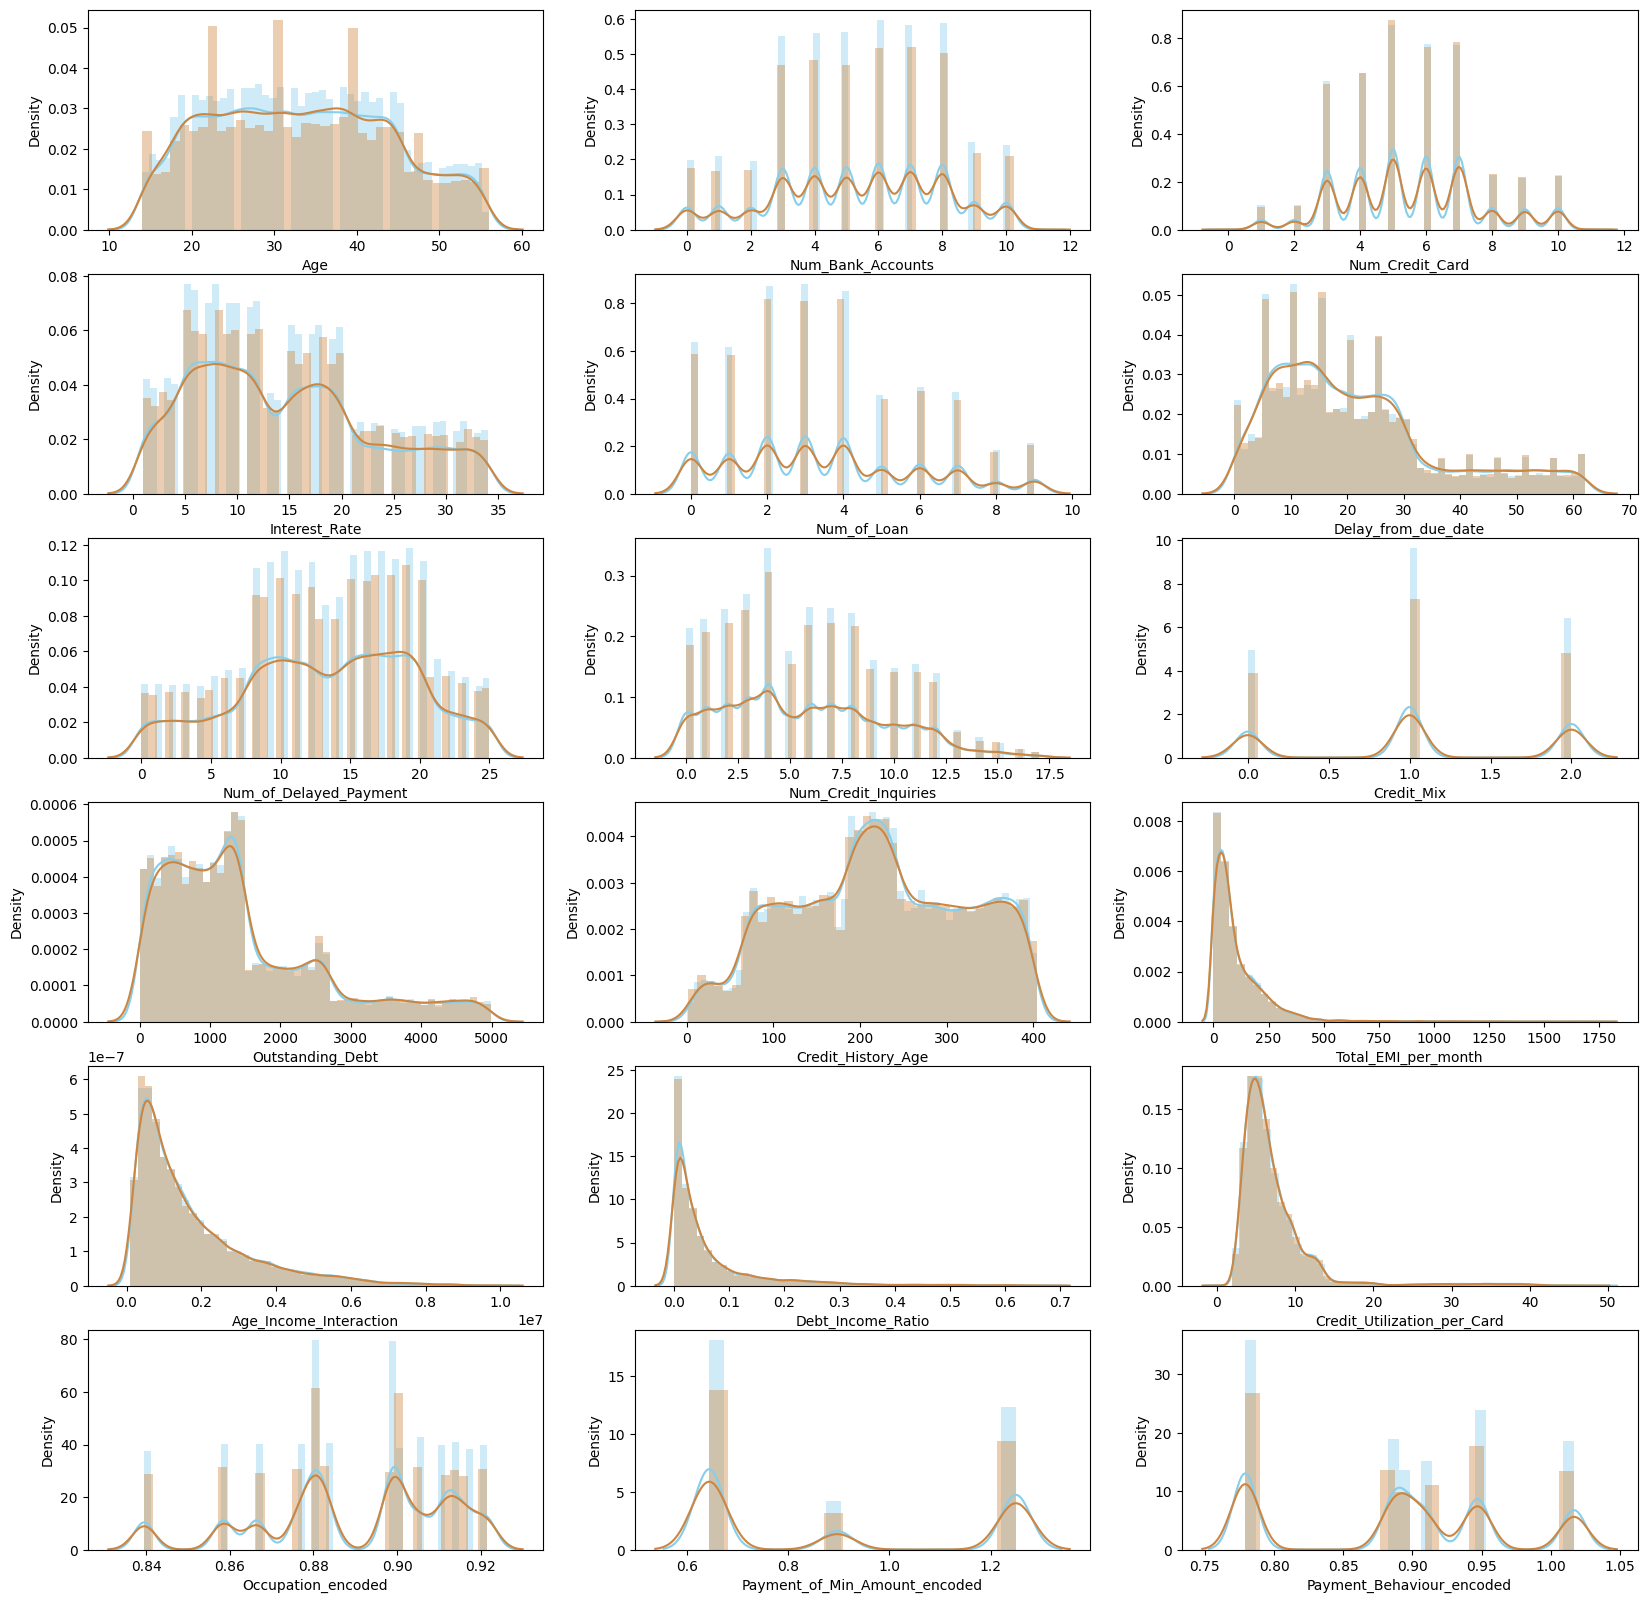

In [ ]:
plt.figure(figsize=(20,20))
for idx in range(18):
  plt.subplot(6,3,idx+1)
  sns.distplot(X_train.iloc[:,idx], color= 'skyblue')
  sns.distplot(X_test.iloc[:, idx], color= 'peru')

In [ ]:
X_train.isnull().sum()

Age                              0
Num_Bank_Accounts                0
Num_Credit_Card                  0
Interest_Rate                    0
Num_of_Loan                      0
Delay_from_due_date              0
Num_of_Delayed_Payment           0
Num_Credit_Inquiries             0
Credit_Mix                       0
Outstanding_Debt                 0
Credit_History_Age               0
Total_EMI_per_month              0
Age_Income_Interaction           0
Debt_Income_Ratio                0
Credit_Utilization_per_Card      0
Occupation_encoded               0
Payment_of_Min_Amount_encoded    0
Payment_Behaviour_encoded        0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          100000 non-null  float64
 1   Occupation                   100000 non-null  object 
 2   Num_Bank_Accounts            100000 non-null  float64
 3   Num_Credit_Card              100000 non-null  float64
 4   Interest_Rate                100000 non-null  float64
 5   Num_of_Loan                  100000 non-null  float64
 6   Delay_from_due_date          100000 non-null  float64
 7   Num_of_Delayed_Payment       100000 non-null  float64
 8   Num_Credit_Inquiries         100000 non-null  float64
 9   Credit_Mix                   100000 non-null  object 
 10  Outstanding_Debt             100000 non-null  float64
 11  Credit_History_Age           100000 non-null  float64
 12  Payment_of_Min_Amount        100000 non-null  object 
 13  

## Re-checking the Correlation Matrix

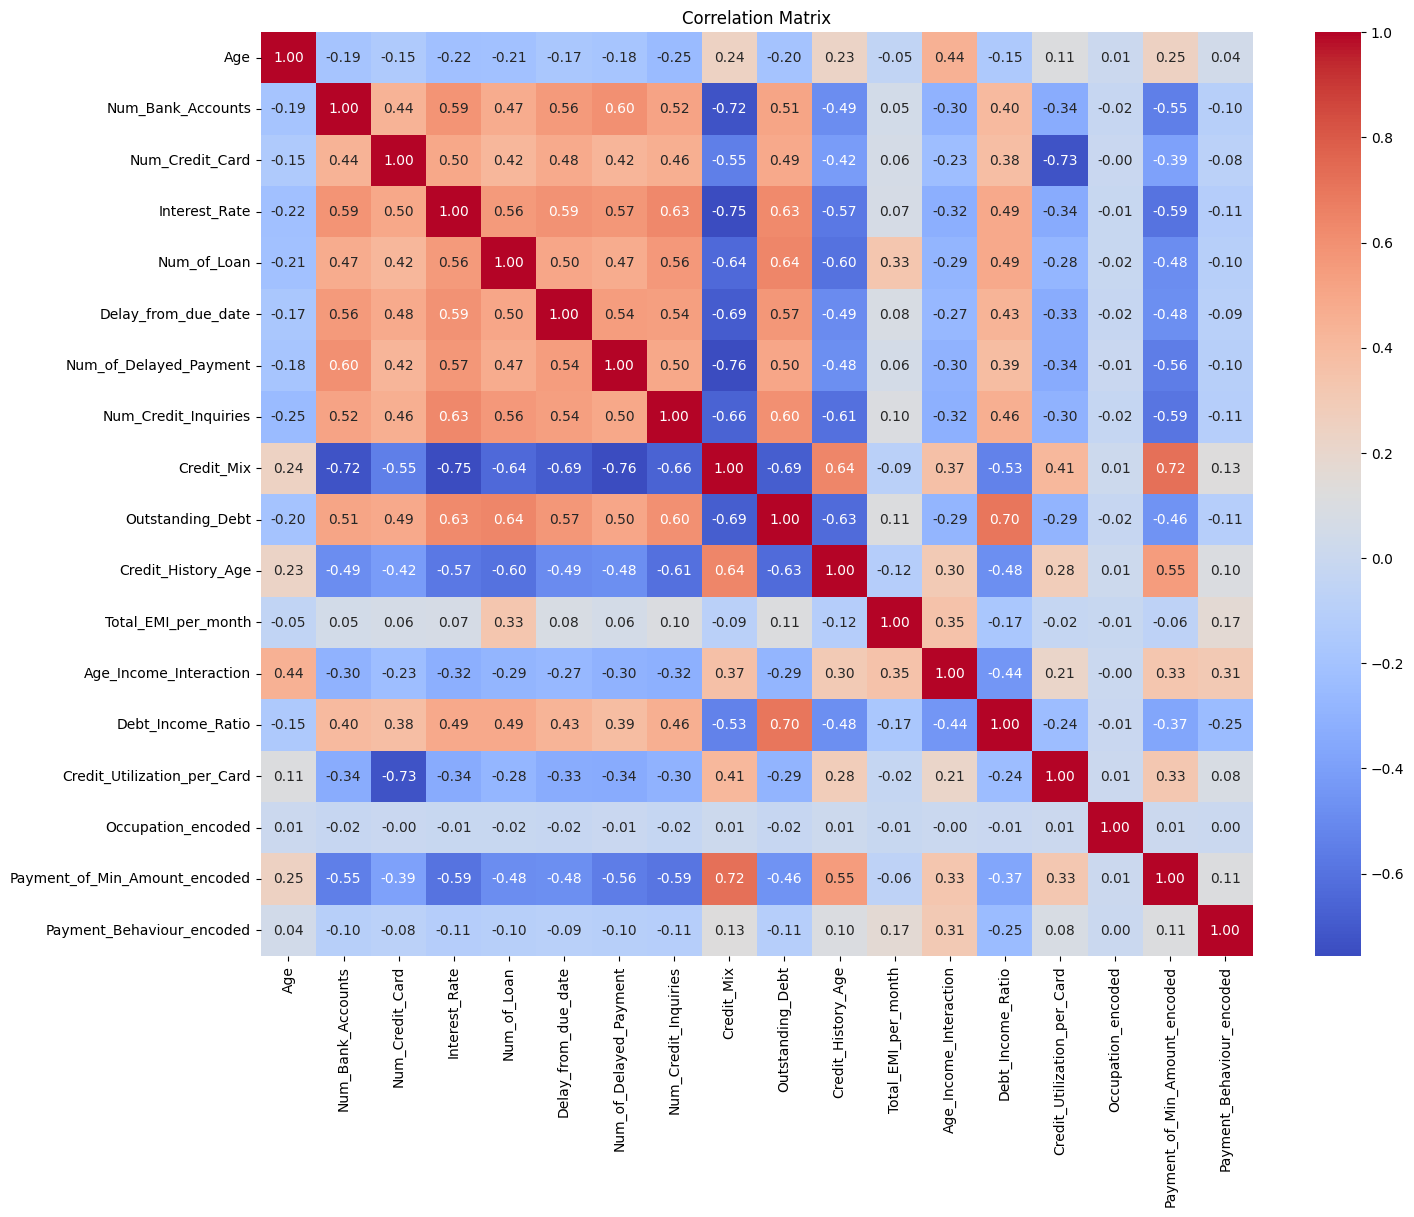

In [ ]:
corr_matrix = X_train.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection

## SelectKBest with mutual_info_regression

In [ ]:
fS = SelectKBest(k='all', score_func=mutual_info_regression)
fS.fit(X_train, y_train.values.ravel())

selected_features_indices = fS.get_support(indices=True)
selected_features = X_train.columns[selected_features_indices]

mutual_info_scores = fS.scores_
mutual_info_series = pd.Series(mutual_info_scores, index=X_train.columns, name='Mutual Information')

mutual_info_sorted = mutual_info_series[selected_features].sort_values(ascending=False)
print(mutual_info_sorted)

Debt_Income_Ratio                0.584234
Outstanding_Debt                 0.577439
Total_EMI_per_month              0.519209
Age_Income_Interaction           0.477152
Credit_Mix                       0.189443
Interest_Rate                    0.169025
Delay_from_due_date              0.118777
Num_Credit_Inquiries             0.117891
Num_Credit_Card                  0.110711
Payment_of_Min_Amount_encoded    0.107317
Num_Bank_Accounts                0.106395
Credit_History_Age               0.100163
Credit_Utilization_per_Card      0.088961
Num_of_Loan                      0.088859
Num_of_Delayed_Payment           0.086937
Age                              0.022776
Payment_Behaviour_encoded        0.009441
Occupation_encoded               0.000000
Name: Mutual Information, dtype: float64


## Using RFE

In [ ]:
model = LogisticRegression(random_state=42)             # LogisticRegression

for n_features in range(12, 16):
    print(f"\nEvaluating with {n_features} features:")

    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector = selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    print("Selected features:", selected_features.tolist())

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    score = f1_score(y_test, y_pred, average='weighted')
    print(f'Weighted F1 Score: {score:.4f}')


Evaluating with 12 features:
Selected features: ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Credit_Utilization_per_Card']
Weighted F1 Score: 0.5918

Evaluating with 13 features:
Selected features: ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Credit_Utilization_per_Card']
Weighted F1 Score: 0.5012

Evaluating with 14 features:
Selected features: ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Credit_Utilization_per_Card', 'O

In [ ]:
model = xgb.XGBClassifier(random_state=42)                    # XGBClassifier

for n_features in range(12, 16):
    print(f"\nEvaluating with {n_features} features:")

    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector = selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    print("Selected features:", selected_features.tolist())

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    score = f1_score(y_test, y_pred, average='weighted')
    print(f'Weighted F1 Score: {score:.4f}')


Evaluating with 12 features:
Selected features: ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Occupation_encoded']
Weighted F1 Score: 0.7755

Evaluating with 13 features:
Selected features: ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Occupation_encoded']
Weighted F1 Score: 0.7739

Evaluating with 14 features:
Selected features: ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Occupation_encoded']
Weig

In [ ]:
model = lgb.LGBMClassifier(random_state=42, verbose=-1)              # LGBMClassifier

for n_features in range(12, 16):
    print(f"\nEvaluating with {n_features} features:")

    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector = selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    print("Selected features:", selected_features.tolist())

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    score = f1_score(y_test, y_pred, average='weighted')
    print(f'Weighted F1 Score: {score:.4f}')


Evaluating with 12 features:
Selected features: ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Occupation_encoded']
Weighted F1 Score: 0.7291

Evaluating with 13 features:
Selected features: ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Occupation_encoded']
Weighted F1 Score: 0.7300

Evaluating with 14 features:
Selected features: ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Occupation_encode

In [ ]:
X_train = X_train[['Age', 'Outstanding_Debt', 'Credit_Mix', 'Debt_Income_Ratio', 'Interest_Rate', 'Age_Income_Interaction', 'Total_EMI_per_month',
      'Num_Credit_Inquiries', 'Delay_from_due_date', 'Payment_of_Min_Amount_encoded', 'Num_Credit_Card', 'Num_Bank_Accounts',
      'Credit_History_Age','Num_of_Delayed_Payment']] # Taking 14 features

X_test = X_test[['Age', 'Outstanding_Debt', 'Credit_Mix', 'Debt_Income_Ratio', 'Interest_Rate', 'Age_Income_Interaction', 'Total_EMI_per_month',
      'Num_Credit_Inquiries', 'Delay_from_due_date', 'Payment_of_Min_Amount_encoded', 'Num_Credit_Card', 'Num_Bank_Accounts',
      'Credit_History_Age','Num_of_Delayed_Payment']] # Taking 14 features

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 14), (30000, 14), (70000,), (30000,))

# Training the Model

## Logistic Regression

### Train the model

In [ ]:
def objective_lr(trial):
    params = {
        'C': trial.suggest_float('C', 0.01, 10),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
    }
    model = LogisticRegression(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=30)

[I 2024-07-25 03:08:31,914] A new study created in memory with name: no-name-dc90a191-b051-4f1e-b12d-28261ee9f69b
[I 2024-07-25 03:08:39,849] Trial 0 finished with value: 0.49597725290797845 and parameters: {'C': 4.607449700420424, 'solver': 'lbfgs', 'max_iter': 907}. Best is trial 0 with value: 0.49597725290797845.
[I 2024-07-25 03:08:48,265] Trial 1 finished with value: 0.4757790758761601 and parameters: {'C': 3.9883474695957846, 'solver': 'liblinear', 'max_iter': 347}. Best is trial 0 with value: 0.49597725290797845.
[I 2024-07-25 03:08:57,313] Trial 2 finished with value: 0.4757790758761601 and parameters: {'C': 5.303210715550391, 'solver': 'liblinear', 'max_iter': 488}. Best is trial 0 with value: 0.49597725290797845.
[I 2024-07-25 03:09:03,064] Trial 3 finished with value: 0.4757790758761601 and parameters: {'C': 6.372866135897824, 'solver': 'liblinear', 'max_iter': 599}. Best is trial 0 with value: 0.49597725290797845.
[I 2024-07-25 03:09:09,515] Trial 4 finished with value: 0.4

In [ ]:
print(f'Best parameters for Logistic Regression: {study_lr.best_params}')

Best parameters for Logistic Regression: {'C': 4.607449700420424, 'solver': 'lbfgs', 'max_iter': 907}


In [ ]:
lr_model = LogisticRegression(**study_lr.best_params, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(C=4.607449700420424, max_iter=907, random_state=42)

### Make predictions

In [ ]:
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_lr = f1_score(y_train, y_pred_train_lr, average='weighted')
test_f1_lr = f1_score(y_test, y_pred_test_lr, average='weighted')

print(f'Logistic Regression - Train F1 Score: {train_f1_lr}')
print(f'Logistic Regression - Test F1 Score: {test_f1_lr}')

Logistic Regression - Train F1 Score: 0.5036238601148438
Logistic Regression - Test F1 Score: 0.5011005303547734


---
**Test F1 Score: 0.5011005303547734**
---
---



## Random Forest Classifier

### Train the model

In [ ]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    model = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-07-22 18:33:31,849] A new study created in memory with name: no-name-1d754064-0c62-49ba-93c3-eddde9952570
[I 2024-07-22 18:36:10,954] Trial 0 finished with value: 0.7205891687188194 and parameters: {'n_estimators': 450, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7205891687188194.
[I 2024-07-22 18:37:13,881] Trial 1 finished with value: 0.7366547594310031 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7366547594310031.
[I 2024-07-22 18:38:10,894] Trial 2 finished with value: 0.7664998315735703 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.7664998315735703.
[I 2024-07-22 18:39:13,317] Trial 3 finished with value: 0.6677953748926141 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 2 with value

In [ ]:
print(f'Best parameters for Random Forest: {study_rf.best_params}')

Best parameters for Random Forest: {'n_estimators': 500, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1}


In [ ]:
rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, min_samples_split=6, n_estimators=500,
                       random_state=42)

### Make predictions

In [ ]:
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_rf = f1_score(y_train, y_pred_train_rf, average='weighted')
test_f1_rf = f1_score(y_test, y_pred_test_rf, average='weighted')

print(f'Random Forest - Train F1 Score: {train_f1_rf}')
print(f'Random Forest - Test F1 Score: {test_f1_rf}')

Random Forest - Train F1 Score: 0.8784941367885503
Random Forest - Test F1 Score: 0.803891947433419


---
**Test F1 Score: 0.803891947433419**
---
---



## HistGradient Boosting Classifier

### Train the model

In [ ]:
def objective_hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_iter': trial.suggest_int('max_iter', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 25),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0)
    }
    model = HistGradientBoostingClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_hgb = optuna.create_study(direction='maximize')
study_hgb.optimize(objective_hgb, n_trials=30)

[I 2024-07-25 03:11:34,100] A new study created in memory with name: no-name-29bdc348-12f5-4918-902e-cdcc868ba796
[I 2024-07-25 03:12:57,384] Trial 0 finished with value: 0.764057610846318 and parameters: {'learning_rate': 0.030743355962606293, 'max_iter': 403, 'max_depth': 12, 'min_samples_leaf': 24, 'l2_regularization': 0.44027905462119177}. Best is trial 0 with value: 0.764057610846318.
[I 2024-07-25 03:13:53,359] Trial 1 finished with value: 0.7705659081152265 and parameters: {'learning_rate': 0.16249048527084073, 'max_iter': 376, 'max_depth': 4, 'min_samples_leaf': 18, 'l2_regularization': 0.18003221775156475}. Best is trial 1 with value: 0.7705659081152265.
[I 2024-07-25 03:15:39,534] Trial 2 finished with value: 0.7850532470891181 and parameters: {'learning_rate': 0.05673206076785449, 'max_iter': 474, 'max_depth': 11, 'min_samples_leaf': 15, 'l2_regularization': 0.3993363805207216}. Best is trial 2 with value: 0.7850532470891181.
[I 2024-07-25 03:16:34,345] Trial 3 finished with

In [ ]:
print(f'Best parameters for Hist Gradient Boosting: {study_hgb.best_params}')

Best parameters for Hist Gradient Boosting: {'learning_rate': 0.144701318561476, 'max_iter': 449, 'max_depth': 11, 'min_samples_leaf': 21, 'l2_regularization': 0.8147192617062473}


In [ ]:
hgb_model = HistGradientBoostingClassifier(**study_hgb.best_params, random_state=42)
hgb_model.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.8147192617062473,
                               learning_rate=0.144701318561476, max_depth=11,
                               max_iter=449, min_samples_leaf=21,
                               random_state=42)

### Make predictions

In [ ]:
y_pred_train_hgb = hgb_model.predict(X_train)
y_pred_test_hgb = hgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_hgb = f1_score(y_train, y_pred_train_hgb, average='weighted')
test_f1_hgb = f1_score(y_test, y_pred_test_hgb, average='weighted')

print(f'Hist Gradient Boosting - Train F1 Score: {train_f1_hgb}')
print(f'Hist Gradient Boosting - Test F1 Score: {test_f1_hgb}')

Hist Gradient Boosting - Train F1 Score: 0.8890954909195581
Hist Gradient Boosting - Test F1 Score: 0.8048929371119551


---
**Test F1 Score: 0.8048929371119551**
---
---



## XGBoost Classifier

### Train the model

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    model = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-07-25 03:45:26,902] A new study created in memory with name: no-name-3556d0ed-0d9e-42fc-bae1-6e0be347930f
[I 2024-07-25 03:46:49,753] Trial 0 finished with value: 0.7981108120967161 and parameters: {'n_estimators': 393, 'learning_rate': 0.042503005423154945, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 0.5424998964919061, 'subsample': 0.8424077427840895, 'colsample_bytree': 0.663217506598986}. Best is trial 0 with value: 0.7981108120967161.
[I 2024-07-25 03:48:21,120] Trial 1 finished with value: 0.8037119195351992 and parameters: {'n_estimators': 293, 'learning_rate': 0.13621922176249202, 'max_depth': 12, 'min_child_weight': 10, 'gamma': 0.40874604658902836, 'subsample': 0.7340607750110124, 'colsample_bytree': 0.935858416606842}. Best is trial 1 with value: 0.8037119195351992.
[I 2024-07-25 03:49:07,930] Trial 2 finished with value: 0.7532298222063285 and parameters: {'n_estimators': 472, 'learning_rate': 0.128546320052836, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0

In [ ]:
print(f'Best parameters for XGBoost: {study_xgb.best_params}')

Best parameters for XGBoost: {'n_estimators': 490, 'learning_rate': 0.10978164898836312, 'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.13918180623909665, 'subsample': 0.9469941265040118, 'colsample_bytree': 0.9121620139166886}


In [ ]:
xgb_model = xgb.XGBClassifier(**study_xgb.best_params, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9121620139166886, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.13918180623909665,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10978164898836312,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=490, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Make predictions

In [ ]:
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_xgb = f1_score(y_train, y_pred_train_xgb, average='weighted')
test_f1_xgb = f1_score(y_test, y_pred_test_xgb, average='weighted')

print(f'XGBoost - Train F1 Score: {train_f1_xgb}')
print(f'XGBoost - Test F1 Score: {test_f1_xgb}')

XGBoost - Train F1 Score: 0.9354703335340789
XGBoost - Test F1 Score: 0.8166165996019655


---
**Test F1 Score: 0.8166165996019655**
---
---



## LightGBM

### Train the model

In [ ]:
def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = lgb.LGBMClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

[I 2024-07-25 04:22:01,241] A new study created in memory with name: no-name-aeae87a0-a8a3-446e-98d9-f2c51cd5fa54


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014140 sec

[I 2024-07-25 04:22:31,353] Trial 0 finished with value: 0.8028739926903892 and parameters: {'num_leaves': 155, 'learning_rate': 0.13853067687382276, 'n_estimators': 133, 'min_child_samples': 83, 'subsample': 0.9993877720158515, 'colsample_bytree': 0.72416344223366}. Best is trial 0 with value: 0.8028739926903892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007838 sec

[I 2024-07-25 04:24:23,211] Trial 1 finished with value: 0.8023639639136722 and parameters: {'num_leaves': 243, 'learning_rate': 0.1593076184349504, 'n_estimators': 347, 'min_child_samples': 83, 'subsample': 0.6180803498736643, 'colsample_bytree': 0.6971952603867666}. Best is trial 0 with value: 0.8028739926903892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012615 sec

[I 2024-07-25 04:24:53,064] Trial 2 finished with value: 0.7756083383444681 and parameters: {'num_leaves': 61, 'learning_rate': 0.06803485914245995, 'n_estimators': 180, 'min_child_samples': 53, 'subsample': 0.5100443785687536, 'colsample_bytree': 0.6191869171377145}. Best is trial 0 with value: 0.8028739926903892.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:26:24,022] Trial 3 finished with value: 0.8056962088912407 and parameters: {'num_leaves': 144, 'learning_rate': 0.09487520534931226, 'n_estimators': 472, 'min_child_samples': 37, 'subsample': 0.8881775714751211, 'colsample_bytree': 0.9410745256769382}. Best is trial 3 with value: 0.8056962088912407.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007934 sec

[I 2024-07-25 04:27:56,829] Trial 4 finished with value: 0.8046393851472384 and parameters: {'num_leaves': 198, 'learning_rate': 0.1140174094559335, 'n_estimators': 415, 'min_child_samples': 34, 'subsample': 0.6490190621127961, 'colsample_bytree': 0.707750742538774}. Best is trial 3 with value: 0.8056962088912407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:30:11,732] Trial 5 finished with value: 0.8017893551387731 and parameters: {'num_leaves': 181, 'learning_rate': 0.16455001273605924, 'n_estimators': 453, 'min_child_samples': 80, 'subsample': 0.8946826211356078, 'colsample_bytree': 0.9977371816866683}. Best is trial 3 with value: 0.8056962088912407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:30:44,907] Trial 6 finished with value: 0.8035887725749344 and parameters: {'num_leaves': 178, 'learning_rate': 0.12107014650061355, 'n_estimators': 122, 'min_child_samples': 55, 'subsample': 0.7755565471506375, 'colsample_bytree': 0.9085526732180982}. Best is trial 3 with value: 0.8056962088912407.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing ro

[I 2024-07-25 04:32:19,615] Trial 7 finished with value: 0.8067609544957894 and parameters: {'num_leaves': 224, 'learning_rate': 0.04080397897926251, 'n_estimators': 362, 'min_child_samples': 28, 'subsample': 0.9626970500854939, 'colsample_bytree': 0.858117189260923}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:33:08,599] Trial 8 finished with value: 0.8026020928439191 and parameters: {'num_leaves': 116, 'learning_rate': 0.06233766430207591, 'n_estimators': 294, 'min_child_samples': 32, 'subsample': 0.8056782892275793, 'colsample_bytree': 0.6064820794811898}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:34:37,005] Trial 9 finished with value: 0.8026509966253581 and parameters: {'num_leaves': 181, 'learning_rate': 0.18765271549082996, 'n_estimators': 422, 'min_child_samples': 30, 'subsample': 0.5448218646625965, 'colsample_bytree': 0.9737444100364114}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:35:51,391] Trial 10 finished with value: 0.803847487386595 and parameters: {'num_leaves': 256, 'learning_rate': 0.026367434679330698, 'n_estimators': 257, 'min_child_samples': 20, 'subsample': 0.9685196436415809, 'colsample_bytree': 0.8423469111256247}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003859 sec

[I 2024-07-25 04:37:15,134] Trial 11 finished with value: 0.8062638684536587 and parameters: {'num_leaves': 98, 'learning_rate': 0.0765836095983681, 'n_estimators': 500, 'min_child_samples': 45, 'subsample': 0.8747739247697373, 'colsample_bytree': 0.8357779233237028}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:38:21,010] Trial 12 finished with value: 0.755051461539789 and parameters: {'num_leaves': 84, 'learning_rate': 0.011693471707333956, 'n_estimators': 350, 'min_child_samples': 47, 'subsample': 0.8719012108888187, 'colsample_bytree': 0.824714819075208}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002374 sec

[I 2024-07-25 04:39:16,369] Trial 13 finished with value: 0.7771967201525017 and parameters: {'num_leaves': 32, 'learning_rate': 0.052128305283906065, 'n_estimators': 498, 'min_child_samples': 62, 'subsample': 0.9356986375333851, 'colsample_bytree': 0.8239373939079863}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing ro

[I 2024-07-25 04:40:25,544] Trial 14 finished with value: 0.8047259224874767 and parameters: {'num_leaves': 109, 'learning_rate': 0.08569561428144518, 'n_estimators': 366, 'min_child_samples': 69, 'subsample': 0.852713659735757, 'colsample_bytree': 0.8748529893815397}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing co

[I 2024-07-25 04:41:29,890] Trial 15 finished with value: 0.8053822632756139 and parameters: {'num_leaves': 225, 'learning_rate': 0.042685634705403076, 'n_estimators': 245, 'min_child_samples': 20, 'subsample': 0.711428464797941, 'colsample_bytree': 0.7874557203629566}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:42:33,836] Trial 16 finished with value: 0.8059634587035232 and parameters: {'num_leaves': 121, 'learning_rate': 0.08787701111905794, 'n_estimators': 395, 'min_child_samples': 44, 'subsample': 0.9363084830399737, 'colsample_bytree': 0.5317535675658582}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014871 sec

[I 2024-07-25 04:43:11,668] Trial 17 finished with value: 0.765225828338604 and parameters: {'num_leaves': 84, 'learning_rate': 0.03015551605596173, 'n_estimators': 209, 'min_child_samples': 69, 'subsample': 0.80897170244476, 'colsample_bytree': 0.7664477213476409}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:45:55,793] Trial 18 finished with value: 0.8048908688487 and parameters: {'num_leaves': 218, 'learning_rate': 0.07298482423130478, 'n_estimators': 499, 'min_child_samples': 100, 'subsample': 0.744949255136676, 'colsample_bytree': 0.9033553958168753}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012619 sec

[I 2024-07-25 04:46:47,188] Trial 19 finished with value: 0.7914202335115198 and parameters: {'num_leaves': 88, 'learning_rate': 0.041520669102463985, 'n_estimators': 308, 'min_child_samples': 42, 'subsample': 0.9988933005721786, 'colsample_bytree': 0.8689844624488322}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013812 sec

[I 2024-07-25 04:47:51,842] Trial 20 finished with value: 0.7464957466513195 and parameters: {'num_leaves': 52, 'learning_rate': 0.012386000339294025, 'n_estimators': 439, 'min_child_samples': 29, 'subsample': 0.9305737374059802, 'colsample_bytree': 0.7954652406904877}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:48:59,783] Trial 21 finished with value: 0.8055550862006882 and parameters: {'num_leaves': 121, 'learning_rate': 0.08393069628179751, 'n_estimators': 390, 'min_child_samples': 48, 'subsample': 0.9304365512263596, 'colsample_bytree': 0.5089996886910974}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007829 sec

[I 2024-07-25 04:50:08,659] Trial 22 finished with value: 0.8053567476366439 and parameters: {'num_leaves': 132, 'learning_rate': 0.10179337224900982, 'n_estimators': 385, 'min_child_samples': 41, 'subsample': 0.8447997938609018, 'colsample_bytree': 0.6308856866327048}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:51:10,840] Trial 23 finished with value: 0.8056467723856671 and parameters: {'num_leaves': 152, 'learning_rate': 0.05512418731164679, 'n_estimators': 327, 'min_child_samples': 27, 'subsample': 0.9488632041455236, 'colsample_bytree': 0.5470286001318667}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009303 sec

[I 2024-07-25 04:52:14,880] Trial 24 finished with value: 0.8058105039121536 and parameters: {'num_leaves': 105, 'learning_rate': 0.12784373599951981, 'n_estimators': 398, 'min_child_samples': 45, 'subsample': 0.9049719609357204, 'colsample_bytree': 0.6738405743859933}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013592 sec

[I 2024-07-25 04:53:34,693] Trial 25 finished with value: 0.8044591659887779 and parameters: {'num_leaves': 96, 'learning_rate': 0.07592354163251512, 'n_estimators': 468, 'min_child_samples': 54, 'subsample': 0.8222930310307515, 'colsample_bytree': 0.7652264419412111}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-25 04:54:30,172] Trial 26 finished with value: 0.8060016932087312 and parameters: {'num_leaves': 165, 'learning_rate': 0.09462100351557626, 'n_estimators': 271, 'min_child_samples': 39, 'subsample': 0.9682953845144391, 'colsample_bytree': 0.551718658037827}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007694 sec

[I 2024-07-25 04:55:31,025] Trial 27 finished with value: 0.8054688271100782 and parameters: {'num_leaves': 204, 'learning_rate': 0.04209646295302394, 'n_estimators': 264, 'min_child_samples': 25, 'subsample': 0.97795620303763, 'colsample_bytree': 0.6597074260467555}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing co

[I 2024-07-25 04:56:19,242] Trial 28 finished with value: 0.8063533340811182 and parameters: {'num_leaves': 161, 'learning_rate': 0.10530331662387589, 'n_estimators': 215, 'min_child_samples': 37, 'subsample': 0.9112850429408337, 'colsample_bytree': 0.8588371493986167}. Best is trial 7 with value: 0.8067609544957894.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008026 sec

[I 2024-07-25 04:56:56,896] Trial 29 finished with value: 0.8054690500388147 and parameters: {'num_leaves': 162, 'learning_rate': 0.1470439876553007, 'n_estimators': 188, 'min_child_samples': 35, 'subsample': 0.7468399475285432, 'colsample_bytree': 0.7386322875109707}. Best is trial 7 with value: 0.8067609544957894.


In [ ]:
print(f'Best parameters for LightGBM: {study_lgb.best_params}')

Best parameters for LightGBM: {'num_leaves': 224, 'learning_rate': 0.04080397897926251, 'n_estimators': 362, 'min_child_samples': 28, 'subsample': 0.9626970500854939, 'colsample_bytree': 0.858117189260923}


In [ ]:
lgb_model = lgb.LGBMClassifier(**study_lgb.best_params, random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1487
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 14
[LightGBM] [Info] Start training from score -1.243159
[LightGBM] [Info] Start training from score -0.629475
[LightGBM] [Info] Start training from score -1.722287


LGBMClassifier(colsample_bytree=0.858117189260923,
               learning_rate=0.04080397897926251, min_child_samples=28,
               n_estimators=362, num_leaves=224, random_state=42,
               subsample=0.9626970500854939)

### Make predictions

In [ ]:
y_pred_train_lgb = lgb_model.predict(X_train)
y_pred_test_lgb = lgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_lgb = f1_score(y_train, y_pred_train_lgb, average='weighted')
test_f1_lgb = f1_score(y_test, y_pred_test_lgb, average='weighted')

print(f'LightGBM - Train F1 Score: {train_f1_lgb}')
print(f'LightGBM - Test F1 Score: {test_f1_lgb}')

LightGBM - Train F1 Score: 0.9068842183202814
LightGBM - Test F1 Score: 0.8160409123179171


---
**Test F1 Score: 0.8160409123179171**
---
---



The Model with the best score is **LightGBM: {'num_leaves': 224, 'learning_rate': 0.04080397897926251, 'n_estimators': 362, 'min_child_samples': 28, 'subsample': 0.9626970500854939, 'colsample_bytree': 0.858117189260923}**
---


---


# Create Pipeline

## Create feature_engineering_pipeline


In [ ]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Age_Income_Interaction'] = X['Age'] * X['Annual_Income']
        X['Debt_Income_Ratio'] = X['Outstanding_Debt'] / X['Annual_Income']

        selected_features = [
            'Age', 'Outstanding_Debt', 'Credit_Mix', 'Debt_Income_Ratio', 'Interest_Rate',
            'Age_Income_Interaction', 'Total_EMI_per_month', 'Num_Credit_Inquiries',
            'Delay_from_due_date', 'Payment_of_Min_Amount_encoded', 'Num_Credit_Card',
            'Num_Bank_Accounts', 'Credit_History_Age', 'Num_of_Delayed_Payment'
        ]

        return X[selected_features]

## Define Model

In [ ]:
model = lgb.LGBMClassifier(
               colsample_bytree=0.858117189260923,
               learning_rate=0.04080397897926251,
               min_child_samples=28,
               n_estimators=362,
               num_leaves=224,
               random_state=42,
               subsample=0.9626970500854939,
               verbosity=-1
)

## Create the final pipeline

In [ ]:
pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering()),
    ('model', model)
])

## Load the data

In [ ]:
url = f'https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

data = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D
To: /content/dataset.csv
100%|██████████| 30.2M/30.2M [00:00<00:00, 40.2MB/s]


In [ ]:
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.map({'Poor': 0, 'Standard': 1, 'Good': 2}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Apply CustomEncoder to the data


In [ ]:
class CustomEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Ensure that Credit_Score is numeric for calculations
        X['Credit_Score'] = LabelEncoder().fit_transform(X['Credit_Score'])
        self.occupation_means = X.groupby('Occupation')['Credit_Score'].mean()
        self.payment_of_min_amount_means = X.groupby('Payment_of_Min_Amount')['Credit_Score'].mean()
        self.payment_behaviour_means = X.groupby('Payment_Behaviour')['Credit_Score'].mean()

        self.credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2}
        return self

    def transform(self, X):
        X = X.copy()
        X['Occupation_encoded'] = X['Occupation'].map(self.occupation_means)
        X['Payment_of_Min_Amount_encoded'] = X['Payment_of_Min_Amount'].map(self.payment_of_min_amount_means)
        X['Payment_Behaviour_encoded'] = X['Payment_Behaviour'].map(self.payment_behaviour_means)

        X.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour'], axis=1, inplace=True)

        X['Credit_Mix'] = X['Credit_Mix'].map(self.credit_mix_map)

        return X

In [ ]:
custom_encoder = CustomEncoder()
custom_encoder.fit(pd.concat([X_train, pd.Series(y_train, name='Credit_Score')], axis=1))

CustomEncoder()

In [ ]:
X_train = custom_encoder.transform(X_train)
X_test = custom_encoder.transform(X_test)

## Fit the data into the pipeline

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                ('model',
                 LGBMClassifier(colsample_bytree=0.858117189260923,
                                learning_rate=0.04080397897926251,
                                min_child_samples=28, n_estimators=362,
                                num_leaves=224, random_state=42,
                                subsample=0.9626970500854939, verbosity=-1))])

In [ ]:
model = pipeline.named_steps['model']
importances = model.feature_importances_
feature_names = pipeline.named_steps['feature_engineering'].transform(X_train).columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

                          feature  importance
12             Credit_History_Age       37991
5          Age_Income_Interaction       25835
6             Total_EMI_per_month       24189
1                Outstanding_Debt       23485
3               Debt_Income_Ratio       21506
0                             Age       20912
8             Delay_from_due_date       20208
13         Num_of_Delayed_Payment       17586
4                   Interest_Rate       15239
7            Num_Credit_Inquiries       12473
11              Num_Bank_Accounts        9772
10                Num_Credit_Card        9101
9   Payment_of_Min_Amount_encoded        2450
2                      Credit_Mix        1431


In [ ]:
drive.mount('/content/drive')
joblib.dump(pipeline, '/content/drive/My Drive/best_pipeline_credit.joblib')

Mounted at /content/drive


['/content/drive/My Drive/best_pipeline_credit.joblib']

## Model Performance

In [ ]:
best_model_path = '/content/drive/My Drive/best_pipeline_credit.joblib'
model_pipeline = joblib.load(best_model_path)

y_pred = model_pipeline.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Weighted F1 Score: {weighted_f1}')

Accuracy: 0.8159666666666666
Weighted F1 Score: 0.8160409123179171


Text(0.5, 1.05, 'Confusion_matrix')

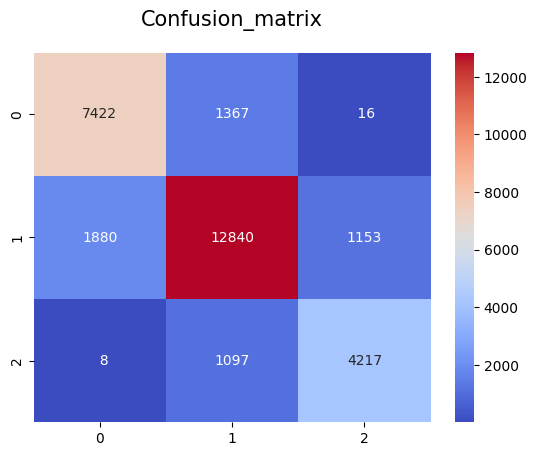

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

# Make new predictions using Streamlit

In [ ]:
!pip install streamlit -q
!pip install pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
%%writefile credit_score_prediction.py
import gdown
import streamlit as st
import joblib
import pandas as pd
import requests
from joblib import load
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Age_Income_Interaction'] = X['Age'] * X['Annual_Income']
        X['Debt_Income_Ratio'] = X['Outstanding_Debt'] / X['Annual_Income']

        selected_features = [
            'Age', 'Outstanding_Debt', 'Credit_Mix', 'Debt_Income_Ratio', 'Interest_Rate',
            'Age_Income_Interaction', 'Total_EMI_per_month', 'Num_Credit_Inquiries',
            'Delay_from_due_date', 'Payment_of_Min_Amount_encoded', 'Num_Credit_Card',
            'Num_Bank_Accounts', 'Credit_History_Age', 'Num_of_Delayed_Payment'
        ]

        return X[selected_features]

class CustomEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = X.copy()
        X['Credit_Score'] = LabelEncoder().fit_transform(X['Credit_Score'])
        self.occupation_means = X.groupby('Occupation')['Credit_Score'].mean()
        self.payment_of_min_amount_means = X.groupby('Payment_of_Min_Amount')['Credit_Score'].mean()
        self.payment_behaviour_means = X.groupby('Payment_Behaviour')['Credit_Score'].mean()
        self.credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2}
        return self

    def transform(self, X):
        X = X.copy()
        X['Occupation_encoded'] = X['Occupation'].map(self.occupation_means)
        X['Payment_of_Min_Amount_encoded'] = X['Payment_of_Min_Amount'].map(self.payment_of_min_amount_means)
        X['Payment_Behaviour_encoded'] = X['Payment_Behaviour'].map(self.payment_behaviour_means)
        X['Credit_Mix'] = X['Credit_Mix'].map(self.credit_mix_map)

        X.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour'], axis=1, inplace=True)

        return X

# Download and load the dataset
url = 'https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)
data = pd.read_csv(output)

label_encoder = LabelEncoder()
credit_score_mapping = {'Poor': 0, 'Standard': 1, 'Good': 2}
data['Credit_Score'] = data['Credit_Score'].map(credit_score_mapping)
label_encoder.fit(data['Credit_Score'])

custom_encoder = CustomEncoder()
data_transformed = custom_encoder.fit_transform(data)

url = 'https://drive.google.com/uc?id=1PsAdcOZx-FateAgSuXcDdIYRnvjTlX8b'
output = 'best_pipeline_credit.joblib'
response = requests.get(url)
with open(output, 'wb') as f:
    f.write(response.content)

# Load the joblib file
pipeline = load(output)

st.title('Credit Score Prediction')

ID = st.number_input('ID', min_value=1, value=1)
Customer_ID = st.number_input('Customer_ID', min_value=1, value=1)
Month = st.number_input('Month', min_value=1, max_value=12, value=7)
Name = st.text_input('Name', 'John Doe')
Age = st.number_input('Age', min_value=14, max_value=100, value=30)
SSN = st.text_input('SSN', '123-45-6789')
Occupation = st.selectbox('Occupation', ['Lawyer', 'Engineer', 'Architect', 'Mechanic', 'Scientist', 'Accountant', 'Developer', 'Media_Manager', 'Teacher','Entrepreneur', 'Doctor', 'Journalist', 'Manager', 'Musician', 'Writer'], index=1)
Annual_Income = st.number_input('Annual_Income', min_value=1000, value=50000)
Monthly_Inhand_Salary = st.number_input('Monthly_Inhand_Salary', min_value=100, value=4000)
Num_Bank_Accounts = st.number_input('Num_Bank_Accounts', min_value=1, value=2)
Num_Credit_Card = st.number_input('Num_Credit_Card', min_value=0, value=1)
Interest_Rate = st.number_input('Interest_Rate', min_value=1.0, format="%.2f", value=5.0)
Num_of_Loan = st.number_input('Num_of_Loan', min_value=0, value=1)
Type_of_Loan = st.selectbox('Type_of_Loan', ['Personal', 'Home', 'Car', 'Education'])
Delay_from_due_date = st.number_input('Delay_from_due_date', min_value=0, value=0)
Num_of_Delayed_Payment = st.number_input('Num_of_Delayed_Payment', min_value=0, value=1)
Changed_Credit_Limit = st.number_input('Changed_Credit_Limit', min_value=0, value=5000)
Num_Credit_Inquiries = st.number_input('Num_Credit_Inquiries', min_value=0, value=1)
Credit_Mix = st.selectbox('Credit_Mix', ['Bad', 'Standard', 'Good'])
Outstanding_Debt = st.number_input('Outstanding_Debt', min_value=0, value=1000)
Credit_Utilization_Ratio = st.number_input('Credit_Utilization_Ratio', min_value=20, value=30)
Credit_History_Age = st.number_input('Credit_History_Age', min_value=0, value=5)
Payment_of_Min_Amount = st.selectbox('Payment_of_Min_Amount', ['Yes', 'No'])
Total_EMI_per_month = st.number_input('Total_EMI_per_month', min_value=0, value=300)
Amount_invested_monthly = st.number_input('Amount_invested_monthly', min_value=0, value=1000)
Payment_Behaviour = st.selectbox('Payment_Behaviour', ['Low', 'Medium', 'High'])
Monthly_Balance = st.number_input('Monthly_Balance', min_value=-5000, value=1000)

new_data = pd.DataFrame({
    'ID': [ID],
    'Customer_ID': [Customer_ID],
    'Month': [Month],
    'Name': [Name],
    'Age': [Age],
    'SSN': [SSN],
    'Occupation': [Occupation],
    'Annual_Income': [Annual_Income],
    'Monthly_Inhand_Salary': [Monthly_Inhand_Salary],
    'Num_Bank_Accounts': [Num_Bank_Accounts],
    'Num_Credit_Card': [Num_Credit_Card],
    'Interest_Rate': [Interest_Rate],
    'Num_of_Loan': [Num_of_Loan],
    'Type_of_Loan': [Type_of_Loan],
    'Delay_from_due_date': [Delay_from_due_date],
    'Num_of_Delayed_Payment': [Num_of_Delayed_Payment],
    'Changed_Credit_Limit': [Changed_Credit_Limit],
    'Num_Credit_Inquiries': [Num_Credit_Inquiries],
    'Credit_Mix': [Credit_Mix],
    'Outstanding_Debt': [Outstanding_Debt],
    'Credit_Utilization_Ratio': [Credit_Utilization_Ratio],
    'Credit_History_Age': [Credit_History_Age],
    'Payment_of_Min_Amount': [Payment_of_Min_Amount],
    'Total_EMI_per_month': [Total_EMI_per_month],
    'Amount_invested_monthly': [Amount_invested_monthly],
    'Payment_Behaviour': [Payment_Behaviour],
    'Monthly_Balance': [Monthly_Balance]
})

new_data_transformed = custom_encoder.transform(new_data)

if st.button('Predict Score'):
    try:
        predicted_score = pipeline.predict(new_data_transformed)
        score_label = label_encoder.inverse_transform(predicted_score)[0]
        score_text = [key for key, value in credit_score_mapping.items() if value == score_label][0]
        st.markdown(f"""
            <div style="display: flex; justify-content: center; align-items: center; padding: 10px; border: 2px solid #4CAF50; border-radius: 10px; background-color: #f9f9f9; margin-top: 20px;">
                <h2 style="color: #4CAF50;">The Predicted Credit Score is: {score_text}</h2>
            </div>
        """, unsafe_allow_html=True)
    except KeyError as e:
        st.error(f"Error: {e}")

Writing credit_score_prediction.py


In [ ]:
from pyngrok import ngrok
import subprocess

ngrok.set_auth_token("2jhoNI1jfLmSpnrRlJ3hzjinWOz_6D3Wi4PDE4vVZrsYPRBY")
ngrok_tunnel = ngrok.connect(8501)
print("Public URL:", ngrok_tunnel.public_url)

subprocess.Popen(["streamlit", "run", "credit_score_prediction.py"])

import time
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Ngrok tunnel stopped.")

Public URL: https://1c88-34-147-10-217.ngrok-free.app
Ngrok tunnel stopped.
